In [ ]:
import pandas as pd
import glob
import pandas as pd
import numpy as np
import scipy
import argparse
import matplotlib.pyplot as plt
import math
import seaborn as sns
from scipy import stats
from numpy import arange
from pandas import read_csv
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.model_selection import GridSearchCV, RepeatedKFold, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import colorConverter, ListedColormap
%matplotlib inline

# To compute distances
from scipy.spatial.distance import cdist

# To perform k-means clustering and compute silhouette scores
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# To visualize the elbow curve and silhouette scores
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

# To compute distances
from scipy.spatial.distance import pdist

# To perform hierarchical clustering, compute cophenetic correlation, and create dendrograms
from sklearn.cluster import AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet

In [ ]:
from google.colab import files

uploaded = files.upload()

Saving BATCH1_v2.csv to BATCH1_v2.csv
Saving BATCH2_v2.csv to BATCH2_v2.csv
Saving BATCH3_v2.csv to BATCH3_v2.csv
Saving BATCH4_v2.csv to BATCH4_v2.csv
Saving TMS_BATCH1_v2.csv to TMS_BATCH1_v2.csv
Saving TMS_BATCH2_v2.csv to TMS_BATCH2_v2.csv
Saving TMS_BATCH3_v2.csv to TMS_BATCH3_v2.csv


In [ ]:
dataframes = []
for file_name in uploaded.keys():
    df = pd.read_csv(file_name)
    dataframes.append(df)


<ipython-input-3-a4c0fe3b23f1>:3: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name)
<ipython-input-3-a4c0fe3b23f1>:3: DtypeWarning: Columns (7,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name)
<ipython-input-3-a4c0fe3b23f1>:3: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name)


In [ ]:
combined_df = pd.concat(dataframes)


In [ ]:
df2 = combined_df

In [ ]:
from datetime import time

# Extract the time component
df2['time'] = pd.to_datetime(df2['SHIP_TIME']).dt.time

# Define time intervals for each category
morning_start = time(6, 0, 0)
morning_end = time(11, 59, 59)
afternoon_start = time(12, 0, 0)
afternoon_end = time(17, 59, 59)
evening_start = time(18, 0, 0)
evening_end = time(23, 59, 59)

# Function to categorize time values
def categorize_time(time_value):
    if morning_start <= time_value <= morning_end:
        return 'Morning'
    elif afternoon_start <= time_value <= afternoon_end:
        return 'Afternoon'
    elif evening_start <= time_value <= evening_end:
        return 'Evening'
    else:
        return 'Overnight'

# Apply the function to create the categories
df2['time_category'] = df2['time'].apply(categorize_time)

In [ ]:
columns_to_drop = ['SHIP_TIME', 'time']
df3 = df2.drop(columns=columns_to_drop)

In [ ]:
df2 = df2.drop(columns=columns_to_drop)

In [ ]:
df2['PH_SCHED_DLVRY_DATE'] = pd.to_datetime(df2['PH_SCHED_DLVRY_DATE'])
df2['SHIP_DATE'] = pd.to_datetime(df2['SHIP_DATE'])


In [ ]:
columns_to_drop2 = ['ORIGIN_ZIP', 'PH_SHIPTO_ZIP']
df2 = df2.drop(columns=columns_to_drop2)

In [ ]:
desired_order = ['CUSTOMER', 'ORIGIN_CITY', 'ORIGIN_STATE', 'ORIGIN_COUNTRY', 'PH_SHIPTO_CITY', 'PH_SHIPTO_STATE', 'PH_SHIPTO_CNTRY_OR_TERRITORY', 'DOM_INTL', 'SHIP_CARRIER', 'SHIP_LOS', 'PH_SCHED_DLVRY_DATE', 'SHIP_DATE', 'OPH_TOTAL_NBR_OF_CARTON', 'OCH_EST_WT', 'OCH_ACTL_WT', 'SHIP_WT_ACCURACY', 'OCH_TOTAL_QTY', 'time_category', 'TMS']
df2 = df2[desired_order]

In [ ]:
df2['TMS'] = df2['TMS'].replace({'Y': 1, 'N': 0})

In [ ]:
bins = [0, 149.999, 19999, 999999]
labels = ['PARCEL', 'FREIGHT', 'TRUCKLOAD']

In [ ]:
df2['EST_WEIGHT_CATEGORY'] = pd.cut(df2['OCH_EST_WT'], bins=bins, labels=labels)
df2['ACT_WEIGHT_CATEGORY'] = pd.cut(df2['OCH_ACTL_WT'], bins=bins, labels=labels)

In [ ]:
columns_to_drop3 = ['OCH_EST_WT', 'OCH_ACTL_WT']
df2 = df2.drop(columns=columns_to_drop3)

In [ ]:
df2['CUSTOMER'] = df2['CUSTOMER'].astype('int32')
df2['OPH_TOTAL_NBR_OF_CARTON'] = df2['OPH_TOTAL_NBR_OF_CARTON'].astype('int32')
df2['OCH_TOTAL_QTY'] = df2['OCH_TOTAL_QTY'].astype('int32')
df2['TMS'] = df2['TMS'].astype('int32')

In [ ]:
df2 = df2.rename(columns={'time_category': 'SHIP_TIME_CATEGORY'})

In [ ]:
df2['EST_WEIGHT_CATEGORY'] = df2['EST_WEIGHT_CATEGORY'].astype('object')
df2['ACT_WEIGHT_CATEGORY'] = df2['ACT_WEIGHT_CATEGORY'].astype('object')

In [ ]:
desired_order2 = ['CUSTOMER', 'ORIGIN_CITY', 'ORIGIN_STATE', 'ORIGIN_COUNTRY', 'PH_SHIPTO_CITY', 'PH_SHIPTO_STATE', 'PH_SHIPTO_CNTRY_OR_TERRITORY', 'DOM_INTL', 'SHIP_CARRIER', 'SHIP_LOS', 'PH_SCHED_DLVRY_DATE', 'SHIP_DATE', 'OPH_TOTAL_NBR_OF_CARTON', 'EST_WEIGHT_CATEGORY', 'ACT_WEIGHT_CATEGORY', 'SHIP_WT_ACCURACY', 'OCH_TOTAL_QTY', 'SHIP_TIME_CATEGORY', 'TMS']
df2 = df2[desired_order2]

In [ ]:
df2.loc[df2['PH_SCHED_DLVRY_DATE'].notnull(), 'PH_SCHED_DLVRY_DATE'] = 1

In [ ]:
df2['PH_SCHED_DLVRY_DATE'] = df2['PH_SCHED_DLVRY_DATE'].fillna(0)

In [ ]:
df2['PH_SCHED_DLVRY_DATE'] = df2['PH_SCHED_DLVRY_DATE'].replace({1: 'YES', 0: 'NO'})


In [ ]:
df2['SHIP_MONTH'] = df2['SHIP_DATE'].dt.month.astype('int32')  # Extract month values from 'SHIP_DATE' column
df2['SHIP_DAY'] = df2['SHIP_DATE'].dt.day_name()  # Extract day of the week values from 'SHIP_DATE' column

In [ ]:
columns_to_drop4 = ['SHIP_DATE']
df2 = df2.drop(columns=columns_to_drop4)

NameError: ignored

In [ ]:
valid_countries = ['US', 'CA', 'JP', 'AU']

# Replace state values with blank if country is not valid
df2.loc[~df2['PH_SHIPTO_CNTRY_OR_TERRITORY'].isin(valid_countries), 'PH_SHIPTO_STATE'] = ''

In [ ]:
df2["PH_SHIPTO_STATE"].fillna("NONE", inplace=True)

In [ ]:
df2['ORIGIN_CITY'] = df2['ORIGIN_CITY'].str.replace('LOUISVILLE', 'Louisville', case=False)

In [ ]:
df2['PH_SHIPTO_STATE'].nunique()

100

In [ ]:
columns_to_drop5 = ['PH_SHIPTO_CITY', 'ORIGIN_COUNTRY']
df2 = df2.drop(columns=columns_to_drop5)

In [ ]:
column_to_move = df2.pop('TMS')  # Remove the column from the DataFrame
df2['TMS'] = column_to_move  # Add the column back to the DataFrame at the last position

In [ ]:
df2['SHIP_MONTH'] = df2['SHIP_MONTH'].astype('object')

In [ ]:
df2['CUSTOMER'] = df2['CUSTOMER'].astype('object')

In [ ]:
# Select string columns
string_columns = df2.select_dtypes(include=['object']).columns

# Apply get_dummies on string columns
df_encoded = pd.get_dummies(df2[string_columns])

# Concatenate the encoded columns with the original DataFrame
df2 = pd.concat([df2.drop(string_columns, axis=1), df_encoded], axis=1)

# Display the updated dataset
df2.head()

<ipython-input-39-fbd7b66c9359>:5: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  df_encoded = pd.get_dummies(df2[string_columns])
<ipython-input-39-fbd7b66c9359>:5: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  df_encoded = pd.get_dummies(df2[string_columns])


,OPH_TOTAL_NBR_OF_CARTON,OCH_TOTAL_QTY,TMS,CUSTOMER_1,CUSTOMER_2,CUSTOMER_3,CUSTOMER_4,CUSTOMER_5,CUSTOMER_6,CUSTOMER_7,...,SHIP_MONTH_3,SHIP_MONTH_11,SHIP_MONTH_12,SHIP_DAY_Friday,SHIP_DAY_Monday,SHIP_DAY_Saturday,SHIP_DAY_Sunday,SHIP_DAY_Thursday,SHIP_DAY_Tuesday,SHIP_DAY_Wednesday
0,1,15,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
1,6,18,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
2,1,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
3,1,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
4,1,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0


In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import SGDClassifier, SGDRegressor
from sklearn.model_selection import train_test_split

#**SKIP STARTING HERE**

In [ ]:
y = df2['TMS']
X = df2.drop('TMS',axis=1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, stratify = y, random_state = 42)

In [ ]:
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold
from sklearn.ensemble import RandomForestClassifier

# Create a RandomForestClassifier instance
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model on the training data
model.fit(X_train, y_train)

# Make predictions on the testing data
predictions = model.predict(X_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)

Accuracy: 0.9999948183306734


In [ ]:
splits = KFold(n_splits=5,shuffle=True)
print("The Random Forest Model ROC_AUC scores are ",cross_val_score(model, X_test, y_test, cv=splits,scoring='roc_auc'))

The Random Forest Model ROC_AUC scores are  [1.         1.         1.         0.99999999 1.         1.
 0.99999998 1.         0.99999994 0.99999999]


In [ ]:
print("The Random Forest Model Accuracy scores are ",cross_val_score(model, X_test, y_test, cv=splits,scoring='accuracy'))

The Random Forest Model Accuracy scores are  [0.99996546 0.99996546 0.99993091 0.99998273 1.         0.99996546
 1.         0.99996546 1.         0.99996546]


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

%matplotlib inline

In [ ]:
y.value_counts()

NameError: ignored

In [ ]:
confusion_matrix(y_test, predictions)

array([[230434,      3],
       [     0, 348527]])

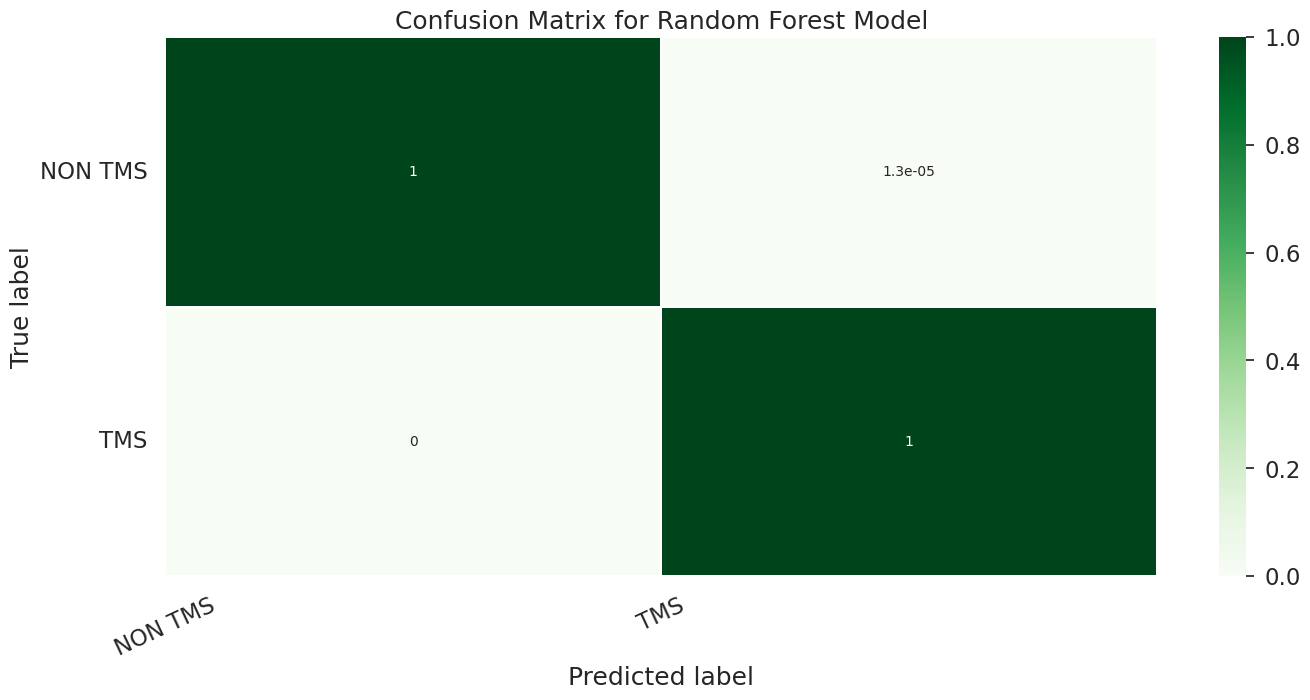

In [ ]:
matrix = confusion_matrix(y_test, predictions)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.5)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['NON TMS', 'TMS']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

In [ ]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    230437
           1       1.00      1.00      1.00    348527

    accuracy                           1.00    578964
   macro avg       1.00      1.00      1.00    578964
weighted avg       1.00      1.00      1.00    578964



In [ ]:
model.feature_importances_

array([4.89522998e-03, 4.43149308e-02, 3.66116776e-03, 3.69802744e-04,
       2.77501526e-05, 4.40021600e-04, 8.12322594e-03, 8.26421034e-05,
       1.54629632e-04, 2.00752216e-03, 2.31139235e-07, 1.23112719e-03,
       7.13769465e-04, 2.13819681e-03, 3.11458613e-05, 5.26031407e-08,
       1.46996781e-03, 5.84618283e-04, 1.65067335e-01, 2.30303385e-04,
       3.01479127e-07, 2.76201032e-02, 9.80714761e-04, 6.34986450e-03,
       2.73087833e-05, 4.67013624e-03, 2.62560766e-04, 3.73559988e-06,
       5.78496972e-04, 1.60605318e-03, 1.55126971e-08, 1.10713054e-03,
       1.99467718e-05, 2.64025846e-05, 1.12408292e-02, 5.52184250e-04,
       1.43033020e-05, 9.93400494e-05, 4.85436029e-05, 1.43438354e-04,
       8.23817808e-05, 3.55567472e-02, 1.77252690e-02, 8.61671699e-02,
       2.53113702e-02, 1.28766160e-03, 2.18072863e-03, 5.39406816e-03,
       2.18693448e-04, 1.02577336e-03, 9.55417596e-05, 1.77324474e-03,
       1.21249314e-04, 6.19532494e-03, 1.21701748e-03, 1.03093634e-04,
      

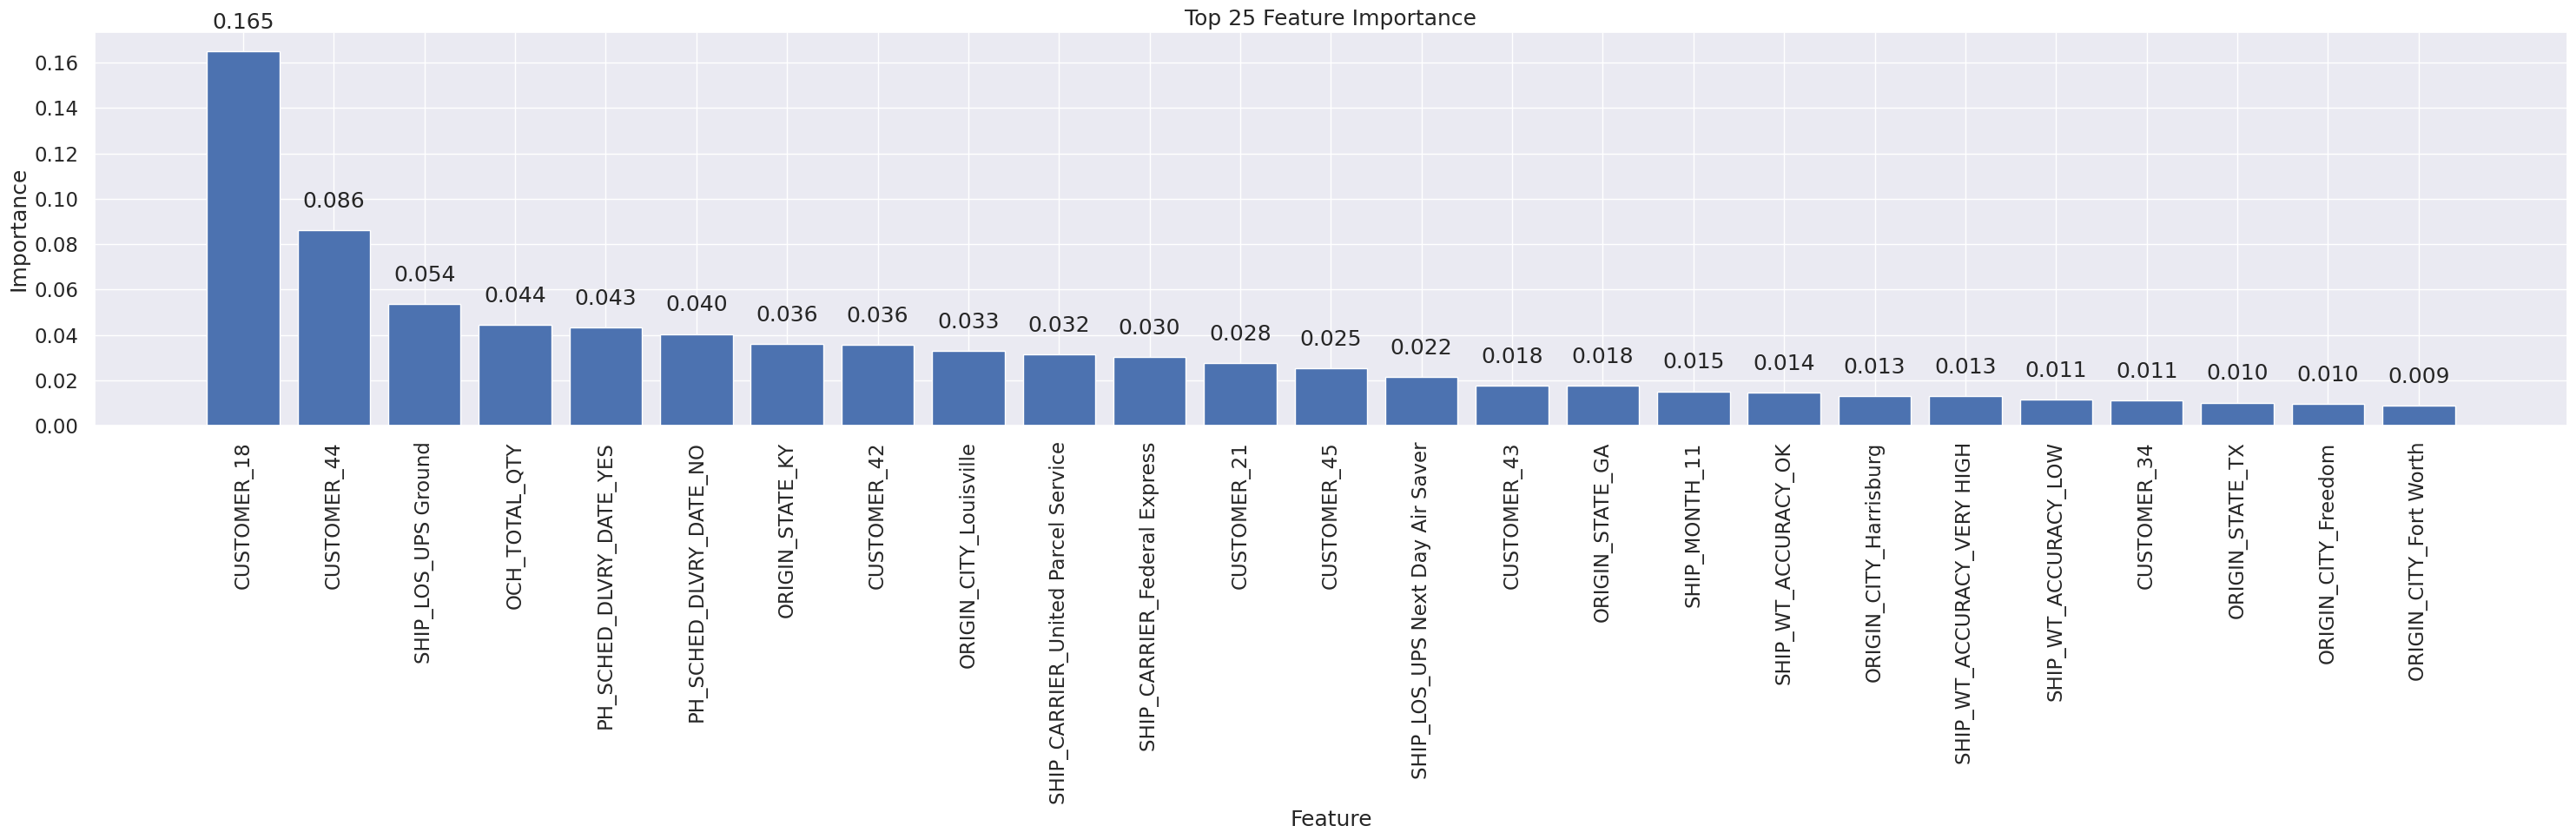

In [ ]:
# Get feature importances from the trained model
importances = model.feature_importances_

# Create a DataFrame with feature names and their importance scores
feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': importances})

# Sort the features by their importance scores
feature_importances = feature_importances.sort_values('Importance', ascending=False)

# Select the top 25 features
top_25_features = feature_importances.head(25)

# Plot the top 25 feature importance with values
plt.figure(figsize=(30, 10))
plt.bar(top_25_features['Feature'], top_25_features['Importance'])
plt.xticks(rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Top 25 Feature Importance')

# Add values to the bars
for i, importance in enumerate(top_25_features['Importance']):
    plt.text(i, importance + 0.01, f'{importance:.3f}', ha='center')

plt.tight_layout()
plt.show()

In [ ]:
# training the classifier on training data
svc = SGDClassifier(loss = "log", n_jobs = -1, max_iter=2, random_state = 42)
svc.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


SGDClassifier(loss='log', max_iter=2, n_jobs=-1, random_state=42)

In [ ]:
y_train_probs = svc.predict_proba(X_train)
y_test_probs = svc.predict_proba(X_test)

In [ ]:
from sklearn.metrics import log_loss
train_loss_svc = log_loss(y_train, y_train_probs)
test_loss_svc = log_loss(y_test, y_test_probs)

print(f"Log loss on Train Data using Support Vectors Model: {train_loss_svc}")
print(f"Log loss on Test Data using Support Vectors Model: {test_loss_svc}")

Log loss on Train Data using Support Vectors Model: 4.533630302858372
Log loss on Test Data using Support Vectors Model: 4.559545110898293


In [ ]:
def plot_confusion_matrix(truths, predictions, labels = df2['TMS'].unique()):
    print("\n")
    matrix = confusion_matrix(truths, predictions)
    # matrix = (4,4) matrix where each cell (i,j) represents number of points of class i which are predicted as of class j
    precision = matrix/np.sum(matrix, axis = 0)
    # precision = (4,4) matrix where each cell (i,j) represents it's precision i.e. TP/(TP+FP) which is value/column_sum in confusion matrix
    recall = (matrix.T/np.sum(matrix, axis = 1)).T
    # recall = (4,4) matrix where each cell (i,j) represents it's recall i.e. TP/(TP+FN) which is value/row_sum in confusion matrix

    # creating axes to draw plots
    fig, ax = plt.subplots(1, 3)
    cmap = sns.light_palette("purple")

    # plotting the matrices using heatmaps from seaborn library
    titles = [("Confusion matrix", matrix), ("Precision matrix", precision), ("Recall matrix", recall)]
    for i, j in enumerate(titles):
        if j[0] == "Confusion matrix":
            sns.heatmap(j[1], annot = True, cmap = cmap, fmt = "", xticklabels = labels, yticklabels = labels, ax = ax[i])
        else:
            sns.heatmap(j[1], annot = True, cmap = cmap, vmin = 0, vmax = 1, fmt = ".2f", xticklabels = labels, yticklabels = labels, ax = ax[i])
        ax[i].set_xticklabels(ax[i].get_xmajorticklabels())
        ax[i].set_yticklabels(ax[i].get_ymajorticklabels(), rotation = 0)
        ax[i].set_title(j[0], fontdict = title_font)
        ax[i].set_xlabel("Predicted labels", fontdict = label_font)
        ax[i].set_ylabel("Original labels", fontdict = label_font)

    # rescaling the figure
    fig.set_figheight(5)
    fig.set_figwidth(15)
    fig.tight_layout()

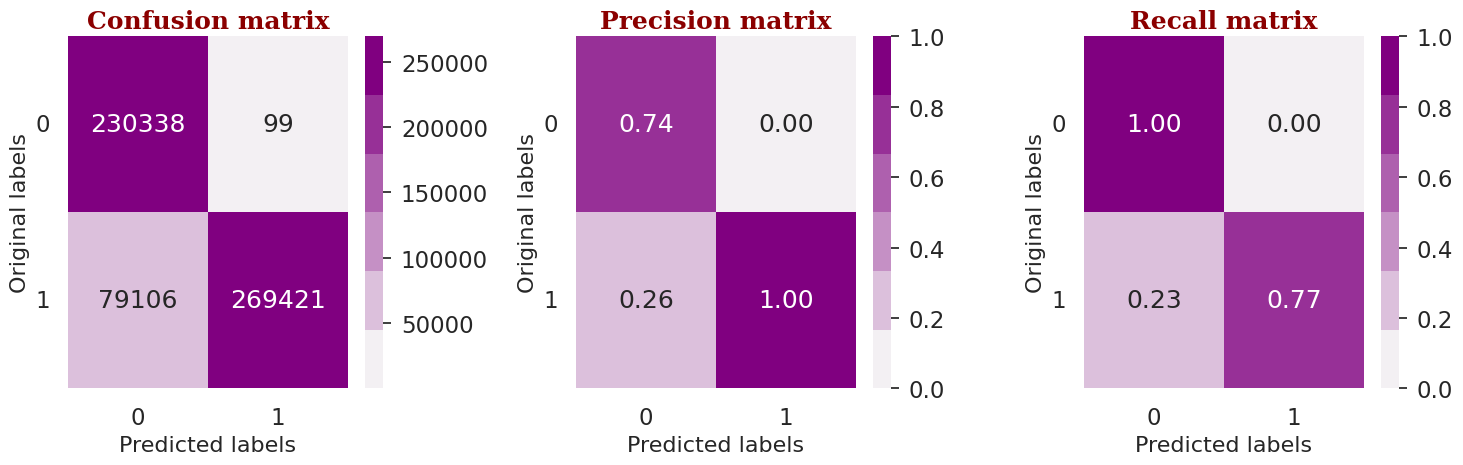

In [ ]:
title_font = {'family': 'serif', 'color': 'darkred', 'weight': 'bold', 'size': 18}
label_font = {'family': 'Georgia', 'weight': 'normal', 'size': 16}
y_test_preds = svc.predict(X_test)
plot_confusion_matrix(y_test, y_test_preds)

In [ ]:
accuracy = accuracy_score(y_test, y_test_preds)
print('SGD Classifier Accuracy of the model: {:.2f}%'.format(accuracy*100))

SGD Classifier Accuracy of the model: 86.32%


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_test_preds))

              precision    recall  f1-score   support

           0       0.74      1.00      0.85    230437
           1       1.00      0.77      0.87    348527

    accuracy                           0.86    578964
   macro avg       0.87      0.89      0.86    578964
weighted avg       0.90      0.86      0.86    578964



In [ ]:
svc_features = svc.coef_[0]

FEATURES1 = pd.DataFrame(svc_features,
             X_train.columns,
             columns=['coef'])\
            .sort_values(by='coef', ascending=False)

print("The top 25 important variables in the SGD Model are \n", FEATURES1[:25])

The top 25 important variables in the SGD Model are 
                                           coef
CUSTOMER_18                         160.075902
SHIP_CARRIER_United Parcel Service  128.056566
ORIGIN_STATE_KY                     127.925431
CUSTOMER_21                         125.881772
SHIP_LOS_UPS Ground                 123.902795
ORIGIN_CITY_Louisville               99.140050
PH_SCHED_DLVRY_DATE_NO               92.906387
SHIP_WT_ACCURACY_OK                  92.809364
EST_WEIGHT_CATEGORY_PARCEL           72.232314
DOM_INTL_DOM                         65.038396
PH_SHIPTO_CNTRY_OR_TERRITORY_US      65.038396
ACT_WEIGHT_CATEGORY_PARCEL           62.914637
SHIP_LOS_UPS Next Day Air            59.890402
ORIGIN_CITY_Freedom                  57.965698
CUSTOMER_34                          54.894633
SHIP_WT_ACCURACY_VERY HIGH           46.250464
SHIP_MONTH_1                         44.726571
SHIP_MONTH_12                        43.896282
CUSTOMER_5                           42.421103
SHIP_M

In [ ]:
import scipy
import argparse
import matplotlib.pyplot as plt
import math
import seaborn as sns
from scipy import stats
from numpy import arange
from pandas import read_csv
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.model_selection import GridSearchCV, RepeatedKFold, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder


In [ ]:
scaler = MinMaxScaler()
Z = df2
cols = Z.columns[Z.columns != 'TMS']
Z[cols] = scaler.fit_transform(Z[cols])

Z

In [ ]:
df_scaled

array([[1.88679245e-03, 9.06786259e-06, 0.00000000e+00, ...,
        0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
       [1.13207547e-02, 1.10109760e-05, 0.00000000e+00, ...,
        0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
       [1.88679245e-03, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
       ...,
       [5.66037736e-03, 7.70768320e-05, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [5.66037736e-03, 7.70768320e-05, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.26415094e-02, 7.70768320e-05, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [ ]:
df2_scaled2 = pd.DataFrame(df_scaled, columns=df.columns)

ValueError: ignored

In [ ]:
y_scaled = df_scaled['TMS']
X_scaled = df_scaled.drop('TMS',axis=1)

In [ ]:
X_trains, X_tests, y_trains, y_tests = train_test_split(X_scaled, y_scaled, test_size = 0.20, stratify = y, random_state = 42)

In [ ]:
LR_Model = LogisticRegression()

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Initialize the logistic regression model
LRmodel = LogisticRegression()

# Train the model on the training data
LRmodel.fit(X_train, y_train)

# Make predictions on the test data
y_pred = LRmodel.predict(X_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.994434887143242


In [ ]:
# Get the feature importance (coefficients) from the model
feature_importance = np.abs(LRmodel.coef_[0])

# Create a dictionary mapping features to their importance
feature_importance_dict = dict(zip(X.columns, feature_importance))

# Sort the features based on importance (descending order)
sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Print the top N most significant features
top_n = 25  # Number of top features to display
for feature, importance in sorted_features[:top_n]:
    print(f"Feature: {feature}, Importance: {importance}")

Feature: CUSTOMER_44, Importance: 15.396629449183518
Feature: CUSTOMER_18, Importance: 11.343621048621548
Feature: CUSTOMER_21, Importance: 7.959499538062442
Feature: CUSTOMER_45, Importance: 6.288253818102838
Feature: CUSTOMER_43, Importance: 6.083057347572208
Feature: CUSTOMER_42, Importance: 5.589790761743597
Feature: ORIGIN_STATE_GA, Importance: 4.308210368894069
Feature: SHIP_LOS_UPS Next Day Air Saver, Importance: 3.730667576749967
Feature: ORIGIN_CITY_Freedom, Importance: 3.7140017278612474
Feature: CUSTOMER_34, Importance: 3.4678015368725843
Feature: ORIGIN_CITY_Harrisburg, Importance: 3.1435335148244876
Feature: CUSTOMER_23, Importance: 3.0343784160496794
Feature: CUSTOMER_5, Importance: 3.0305882725259976
Feature: ORIGIN_STATE_KY, Importance: 2.8147927241774213
Feature: CUSTOMER_56, Importance: 2.7951840498189027
Feature: CUSTOMER_48, Importance: 2.7708015100870567
Feature: ORIGIN_CITY_Buford, Importance: 2.7708015100870567
Feature: ORIGIN_CITY_Fort Worth, Importance: 2.58184

In [ ]:
FEATURES = pd.DataFrame(feature_importance,
             X.columns,
             columns=['coef'])\
            .sort_values(by='coef', ascending=False)

print("The top 25 important variables in the FINAL LR Model are \n", FEATURES[:25])


The top 25 important variables in the FINAL LR Model are 
                                       coef
CUSTOMER_44                      15.396629
CUSTOMER_18                      11.343621
CUSTOMER_21                       7.959500
CUSTOMER_45                       6.288254
CUSTOMER_43                       6.083057
CUSTOMER_42                       5.589791
ORIGIN_STATE_GA                   4.308210
SHIP_LOS_UPS Next Day Air Saver   3.730668
ORIGIN_CITY_Freedom               3.714002
CUSTOMER_34                       3.467802
ORIGIN_CITY_Harrisburg            3.143534
CUSTOMER_23                       3.034378
CUSTOMER_5                        3.030588
ORIGIN_STATE_KY                   2.814793
CUSTOMER_56                       2.795184
ORIGIN_CITY_Buford                2.770802
CUSTOMER_48                       2.770802
ORIGIN_CITY_Fort Worth            2.581841
ORIGIN_STATE_TX                   2.581841
SHIP_LOS_UPS 2nd Day Air          2.562228
CUSTOMER_1                        2.55

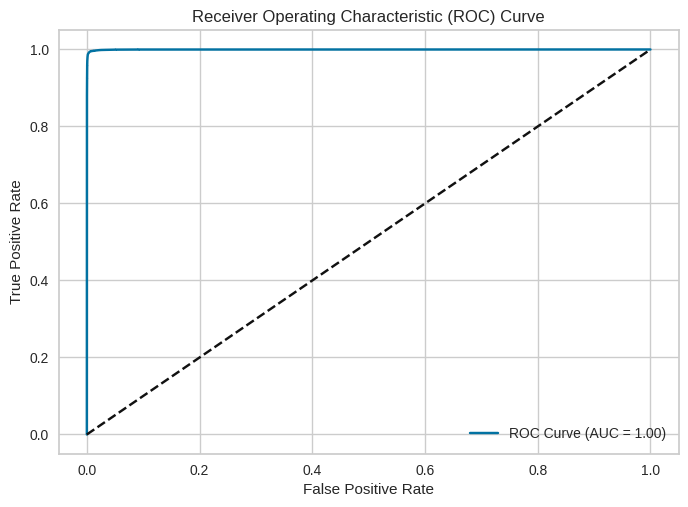

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Assuming you have a logistic regression model named 'LRmodel' trained on data 'X' and target 'y'

# Make predictions on the test data
y_pred_prob = LRmodel.predict_proba(X_test)[:, 1]

# Calculate the fpr, tpr, and threshold values for the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Calculate the AUC score
auc_score = roc_auc_score(y_test, y_pred_prob)

# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC Curve (AUC = {:.2f})'.format(auc_score))
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random guess
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

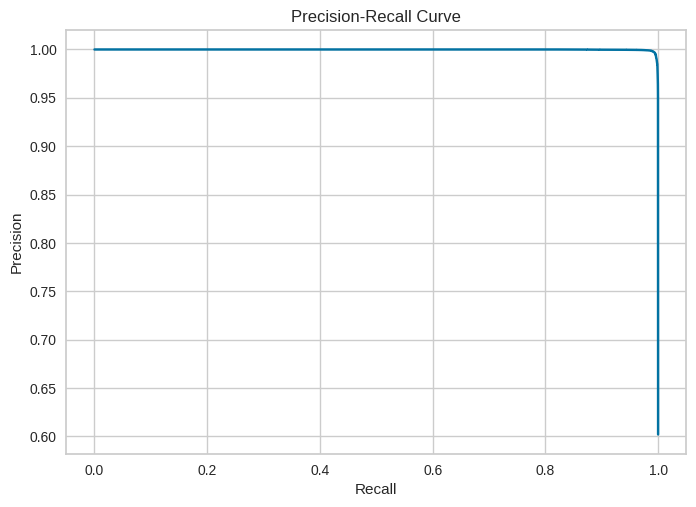

In [ ]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Assuming you have a logistic regression model named 'LRmodel' trained on data 'X' and target 'y'

# Make predictions on the test data
y_pred_prob = LRmodel.predict_proba(X_test)[:, 1]

# Calculate precision and recall values at different thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)

# Plot the Precision-Recall curve
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

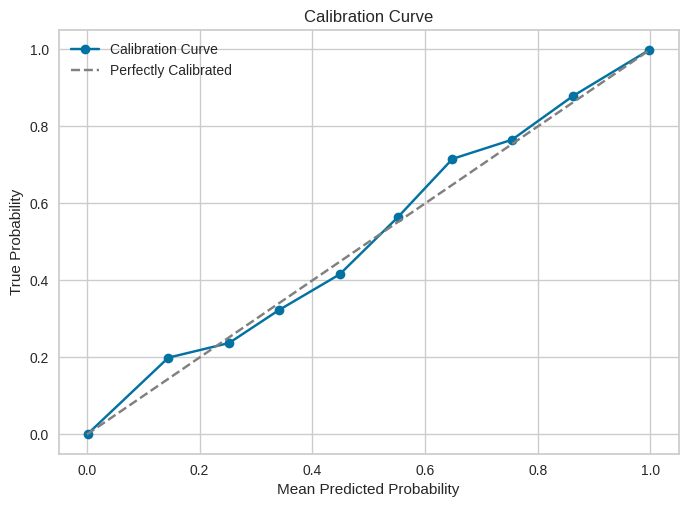

In [ ]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

# Assuming you have a logistic regression model named 'LRmodel' trained on data 'X' and target 'y'

# Make predictions on the test data
y_pred_prob = LRmodel.predict_proba(X_test)[:, 1]

# Calculate the predicted probabilities and true probabilities for the calibration curve
prob_true, prob_pred = calibration_curve(y_test, y_pred_prob, n_bins=10)

# Plot the Calibration Curve
plt.plot(prob_pred, prob_true, marker='o', linestyle='-', label='Calibration Curve')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('True Probability')
plt.title('Calibration Curve')
plt.legend()
plt.show()

In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Create an XGBoost classifier
XGBmodel = xgb.XGBClassifier()

# Train the model on the training data
XGBmodel.fit(X_train, y_train)

# Make predictions on the test data
XGBy_pred = XGBmodel.predict(X_test)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, XGBy_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 100.00%


In [ ]:
# Get the feature importances from the trained model
importances = XGBmodel.feature_importances_

# Get the corresponding feature names
feature_names = X.columns

# Create a dictionary mapping feature names to importances
feature_importances = dict(zip(feature_names, importances))

# Sort the feature importances dictionary by importance scores
sorted_importances = sorted(feature_importances.items(), key=lambda x: x[1], reverse=True)

# Get the top 25 most significant features
top_features = sorted_importances[:50]

# Print the top features and their importances
for feature, importance in top_features:
    print(f"{feature}: {importance}")

CUSTOMER_18: 0.43695932626724243
ORIGIN_STATE_KY: 0.16291014850139618
CUSTOMER_21: 0.11976772546768188
ORIGIN_CITY_Memphis: 0.040296245366334915
CUSTOMER_22: 0.03208686783909798
CUSTOMER_43: 0.030539369210600853
CUSTOMER_44: 0.02505095675587654
CUSTOMER_23: 0.02377924881875515
CUSTOMER_2: 0.014495263807475567
CUSTOMER_56: 0.01081645768135786
CUSTOMER_10: 0.010511701926589012
CUSTOMER_35: 0.008188419975340366
CUSTOMER_34: 0.0075142886489629745
CUSTOMER_42: 0.006905672140419483
CUSTOMER_1: 0.006629152689129114
CUSTOMER_8: 0.00636511342599988
SHIP_LOS_UPS Ground: 0.00613943999633193
CUSTOMER_48: 0.0056823440827429295
ORIGIN_CITY_Harrisburg: 0.005605565384030342
SHIP_CARRIER_Federal Express: 0.004487044643610716
CUSTOMER_45: 0.004265339579433203
CUSTOMER_46: 0.0033964700996875763
CUSTOMER_5: 0.0031016936991363764
SHIP_LOS_UPS 2nd Day Air: 0.0030088189523667097
CUSTOMER_25: 0.002905311295762658


In [ ]:
df_ALLNEW = df2.drop('CUSTOMER', axis=1).copy()

KeyError: ignored

#**END SKIP HERE**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import argparse
import math
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss
from scipy import stats
from numpy import arange
from pandas import read_csv
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.model_selection import GridSearchCV, RepeatedKFold, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve
from sklearn.calibration import calibration_curve

%matplotlib inline

In [ ]:
df_NEW = df2.copy().filter(regex='^(?!CUSTOMER)')


#**SKIP AGAIN**

In [ ]:
y_NEW = df_NEW['TMS']
X_NEW = df_NEW.drop('TMS',axis=1)

In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X_trainNEW, X_testNEW, y_trainNEW, y_testNEW = train_test_split(X_NEW, y_NEW, test_size = 0.20, random_state = 42)

NameError: ignored

In [ ]:
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold
from sklearn.ensemble import RandomForestClassifier

# Create a RandomForestClassifier instance
RFmodelNEW = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model on the training data
RFmodelNEW.fit(X_trainNEW, y_trainNEW)

# Make predictions on the testing data
RFpredictions = RFmodelNEW.predict(X_testNEW)

# Calculate the accuracy of the model
RFaccuracy = accuracy_score(y_testNEW, RFpredictions)
print("Accuracy:", RFaccuracy)

Accuracy: 0.9814841682729841


In [ ]:
splits = KFold(n_splits=5,shuffle=True)
print("The Random Forest Model ROC_AUC scores are ",cross_val_score(RFmodelNEW, X_testNEW, y_testNEW, cv=splits,scoring='roc_auc'))

The Random Forest Model ROC_AUC scores are  [0.99655736 0.99682417 0.99680384 0.99680059 0.99659685]


In [ ]:
print("The Random Forest Model Accuracy scores are ",cross_val_score(RFmodelNEW, X_testNEW, y_testNEW, cv=splits,scoring='accuracy'))

The Random Forest Model Accuracy scores are  [0.97891928 0.97986925 0.97914382 0.9785652  0.97906591]


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

%matplotlib inline

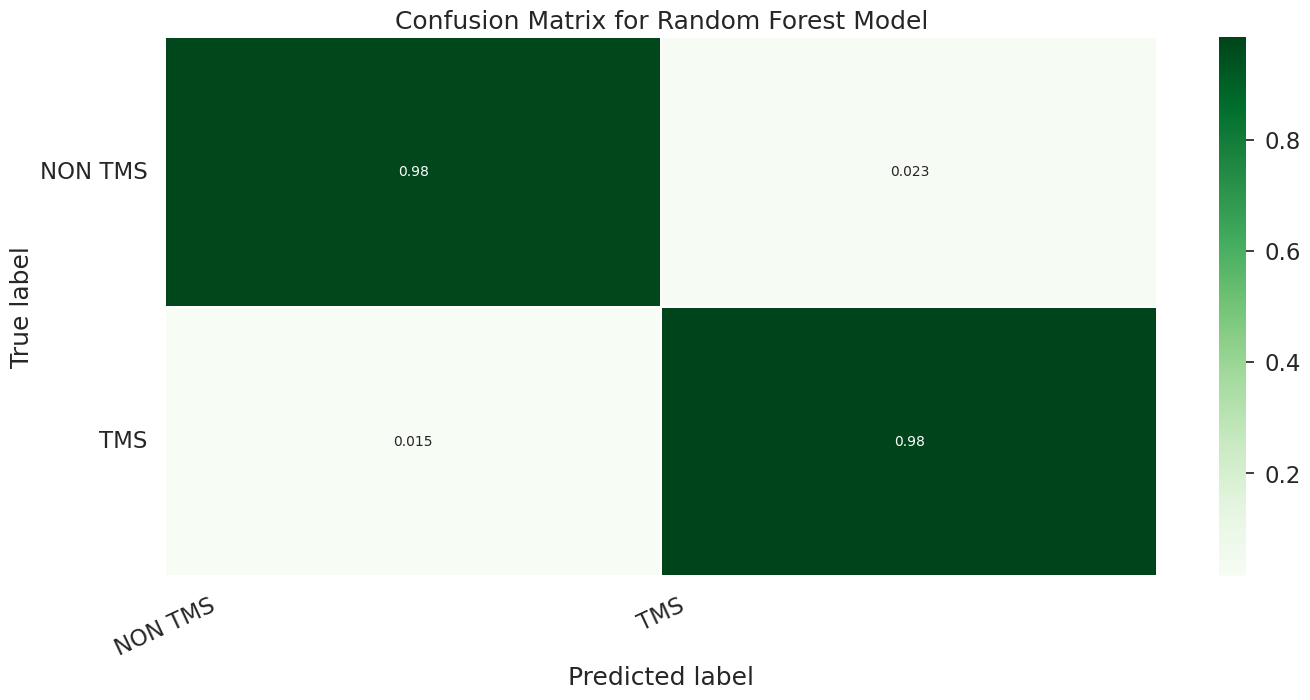

In [ ]:
matrix = confusion_matrix(y_testNEW, RFpredictions)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.5)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['NON TMS', 'TMS']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

In [ ]:
# Assuming you have trained a Random Forest model named 'RFmodelNEW' on data 'X' and target 'y'

# Get the feature importances from the trained model
importances = RFmodelNEW.feature_importances_

# Get the corresponding feature names
feature_names = X_NEW.columns

# Create a dictionary mapping feature names to importances
feature_importances = dict(zip(feature_names, importances))

# Sort the feature importances dictionary by importance scores
sorted_importances = sorted(feature_importances.items(), key=lambda x: x[1], reverse=True)

# Get the top 25 features and their importances
top_features = sorted_importances[:25]

# Print the top 25 features and their importances
for feature, importance in top_features:
    print(f"{feature}: {importance}")

OCH_TOTAL_QTY: 0.12493255487051684
SHIP_LOS_UPS Ground: 0.08547005357095351
PH_SCHED_DLVRY_DATE_YES: 0.05059302952072832
PH_SCHED_DLVRY_DATE_NO: 0.04695310268398422
ORIGIN_STATE_KY: 0.044390335543922445
ORIGIN_CITY_Louisville: 0.04430237705179407
SHIP_CARRIER_Federal Express: 0.043024144379604695
SHIP_LOS_UPS Next Day Air Saver: 0.04220299932817326
SHIP_CARRIER_United Parcel Service: 0.041779264817594496
SHIP_WT_ACCURACY_OK: 0.034427713741163934
SHIP_MONTH_11: 0.03417160071683594
SHIP_WT_ACCURACY_VERY HIGH: 0.02696086925889004
ORIGIN_CITY_Harrisburg: 0.025364118056839902
ORIGIN_STATE_GA: 0.020828382408650273
ORIGIN_CITY_Freedom: 0.020433823192039912
ORIGIN_STATE_PA: 0.019524256103544853
SHIP_WT_ACCURACY_LOW: 0.018504263610601493
ORIGIN_CITY_Fort Worth: 0.016327386396312725
ORIGIN_STATE_TX: 0.015559992345896103
OPH_TOTAL_NBR_OF_CARTON: 0.01517974151439499
SHIP_WT_ACCURACY_HIGH: 0.012593277679792639
SHIP_WT_ACCURACY_VERY LOW: 0.011032538410136931
SHIP_LOS_FedEx Custom Critical: 0.0104003

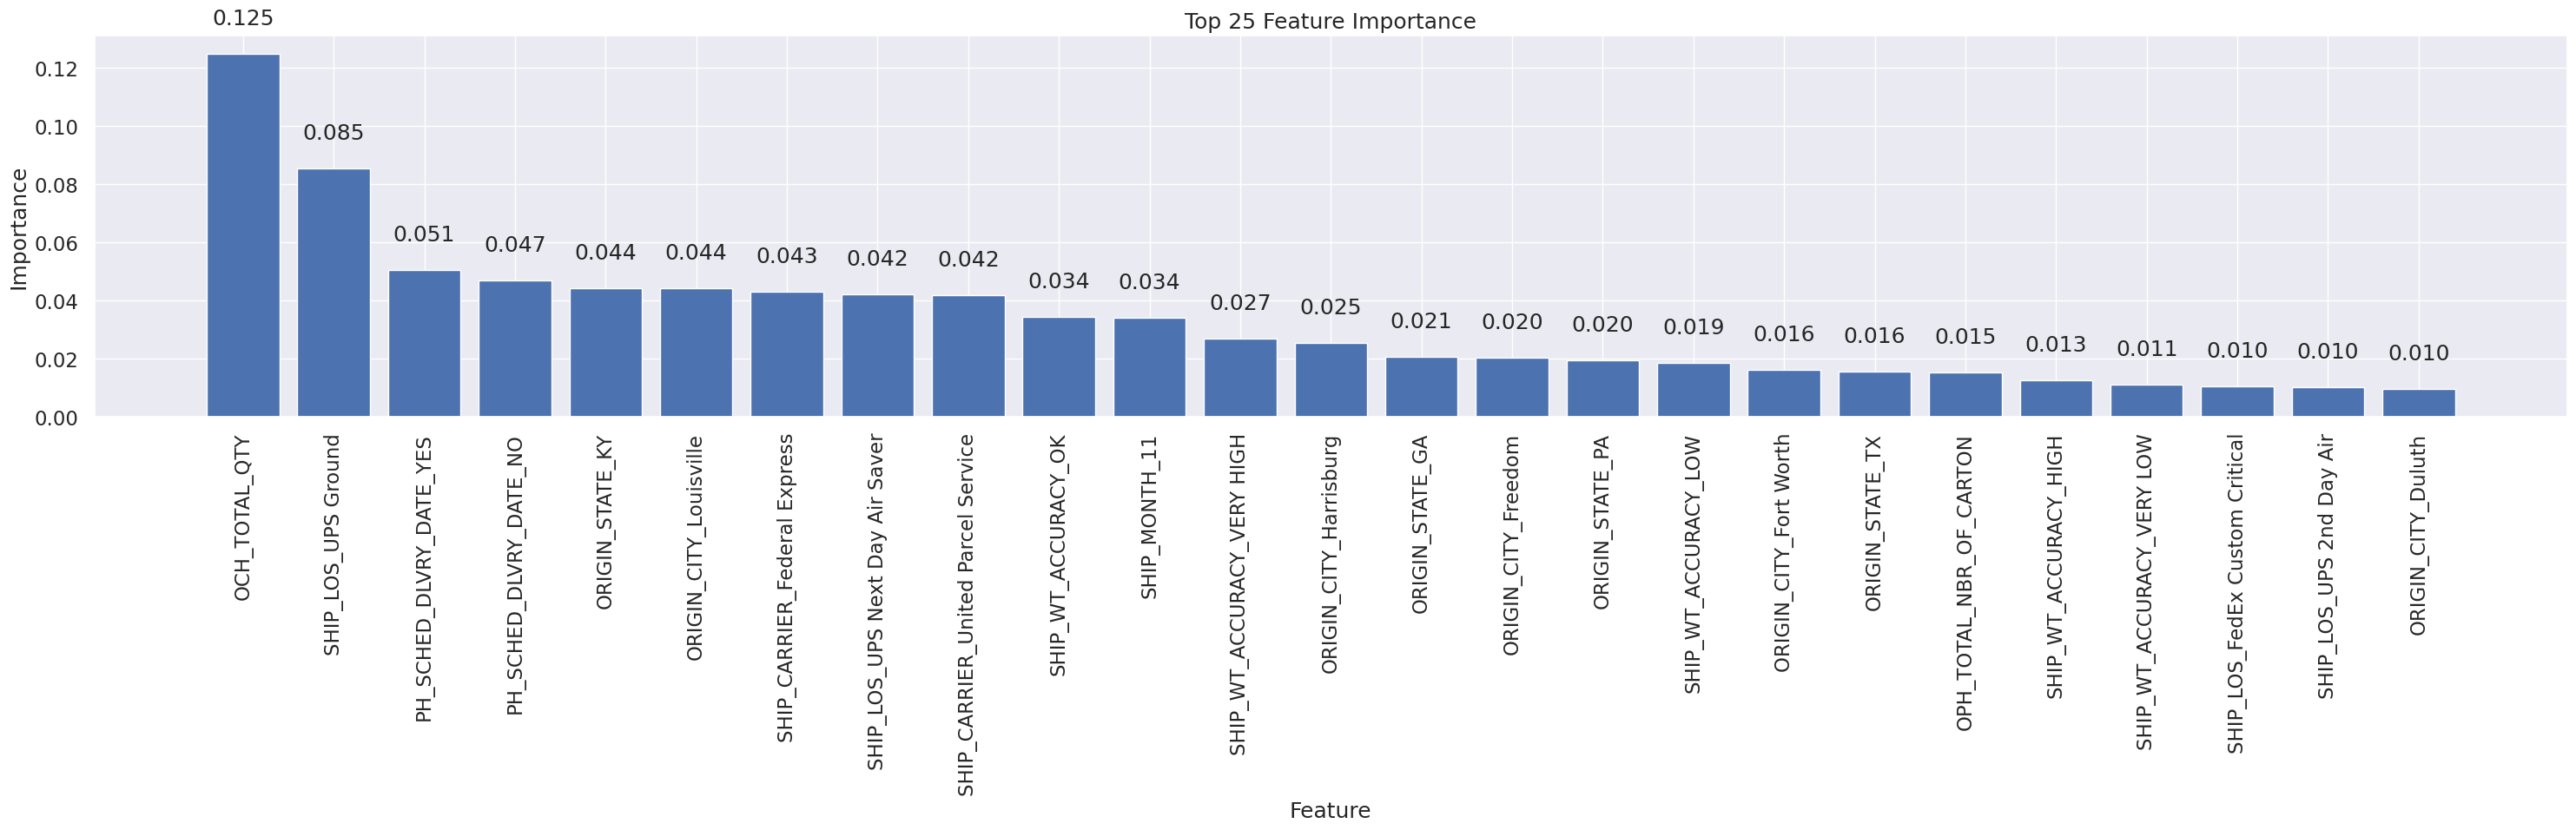

In [ ]:
# Get feature importances from the trained model
importances = RFmodelNEW.feature_importances_

# Create a DataFrame with feature names and their importance scores
feature_importances = pd.DataFrame({'Feature': X_NEW.columns, 'Importance': importances})

# Sort the features by their importance scores
feature_importances = feature_importances.sort_values('Importance', ascending=False)

# Select the top 25 features
top_25_features = feature_importances.head(25)

# Plot the top 25 feature importance with values
plt.figure(figsize=(30, 10))
plt.bar(top_25_features['Feature'], top_25_features['Importance'])
plt.xticks(rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Top 25 Feature Importance')

# Add values to the bars
for i, importance in enumerate(top_25_features['Importance']):
    plt.text(i, importance + 0.01, f'{importance:.3f}', ha='center')

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import SGDClassifier, SGDRegressor
from sklearn.model_selection import train_test_split

In [ ]:
# training the classifier on training data
svcNEW = SGDClassifier(loss = "log", n_jobs = -1, max_iter=2, random_state = 42)
svcNEW.fit(X_trainNEW, y_trainNEW)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


SGDClassifier(loss='log', max_iter=2, n_jobs=-1, random_state=42)

In [ ]:
y_train_probsNEW = svcNEW.predict_proba(X_trainNEW)
y_test_probsNEW = svcNEW.predict_proba(X_testNEW)

In [ ]:
from sklearn.metrics import log_loss
train_loss_svcNEW = log_loss(y_trainNEW, y_train_probsNEW)
test_loss_svcNEW = log_loss(y_testNEW, y_test_probsNEW)

print(f"Log loss on Train Data using Support Vectors Model: {train_loss_svcNEW}")
print(f"Log loss on Test Data using Support Vectors Model: {test_loss_svcNEW}")

Log loss on Train Data using Support Vectors Model: 4.897188025855491
Log loss on Test Data using Support Vectors Model: 4.925420022496937


In [ ]:
def plot_confusion_matrix(truths, predictions, labels = df_NEW['TMS'].unique()):
    print("\n")
    matrix = confusion_matrix(truths, predictions)
    # matrix = (4,4) matrix where each cell (i,j) represents number of points of class i which are predicted as of class j
    precision = matrix/np.sum(matrix, axis = 0)
    # precision = (4,4) matrix where each cell (i,j) represents it's precision i.e. TP/(TP+FP) which is value/column_sum in confusion matrix
    recall = (matrix.T/np.sum(matrix, axis = 1)).T
    # recall = (4,4) matrix where each cell (i,j) represents it's recall i.e. TP/(TP+FN) which is value/row_sum in confusion matrix

    # creating axes to draw plots
    fig, ax = plt.subplots(1, 3)
    cmap = sns.light_palette("purple")

    # plotting the matrices using heatmaps from seaborn library
    titles = [("Confusion matrix", matrix), ("Precision matrix", precision), ("Recall matrix", recall)]
    for i, j in enumerate(titles):
        if j[0] == "Confusion matrix":
            sns.heatmap(j[1], annot = True, cmap = cmap, fmt = "", xticklabels = labels, yticklabels = labels, ax = ax[i])
        else:
            sns.heatmap(j[1], annot = True, cmap = cmap, vmin = 0, vmax = 1, fmt = ".2f", xticklabels = labels, yticklabels = labels, ax = ax[i])
        ax[i].set_xticklabels(ax[i].get_xmajorticklabels())
        ax[i].set_yticklabels(ax[i].get_ymajorticklabels(), rotation = 0)
        ax[i].set_title(j[0], fontdict = title_font)
        ax[i].set_xlabel("Predicted labels", fontdict = label_font)
        ax[i].set_ylabel("Original labels", fontdict = label_font)

    # rescaling the figure
    fig.set_figheight(5)
    fig.set_figwidth(15)
    fig.tight_layout()

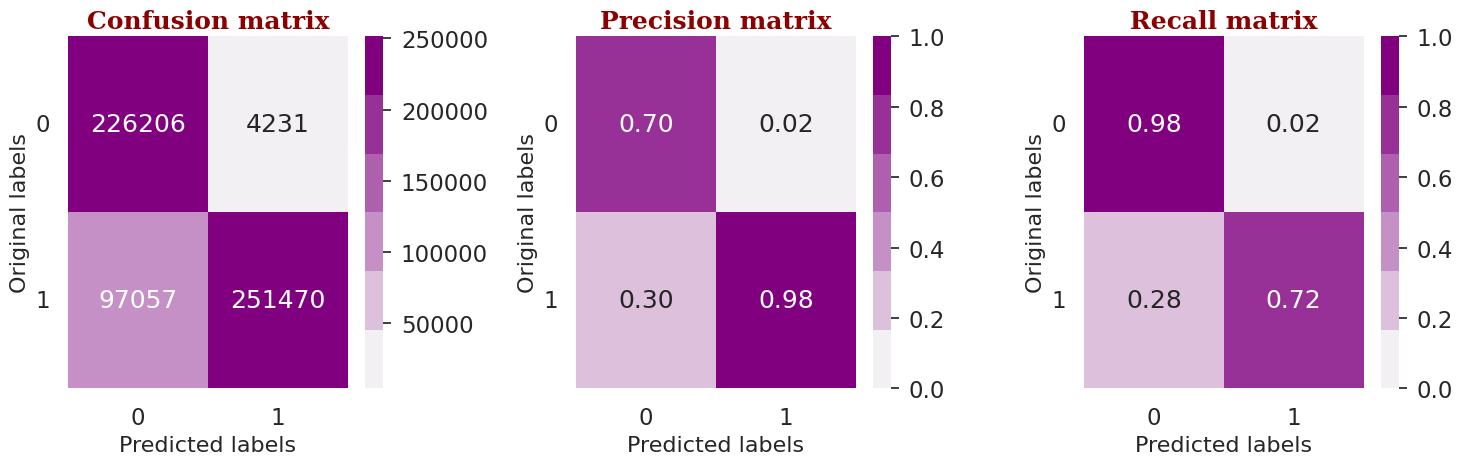

In [ ]:
title_font = {'family': 'serif', 'color': 'darkred', 'weight': 'bold', 'size': 18}
label_font = {'family': 'Courier New', 'weight': 'normal', 'size': 16}
y_test_predsNEW = svcNEW.predict(X_testNEW)
plot_confusion_matrix(y_testNEW, y_test_predsNEW)

In [ ]:
accuracyNEW = accuracy_score(y_testNEW, y_test_predsNEW)
print('SGD Classifier Accuracy of the model: {:.2f}%'.format(accuracyNEW*100))

SGD Classifier Accuracy of the model: 82.51%


In [ ]:
svc_featuresNEW = svcNEW.coef_[0]

FEATURES2 = pd.DataFrame(svc_featuresNEW,
             X_trainNEW.columns,
             columns=['coef'])\
            .sort_values(by='coef', ascending=False)

print("The top 25 important variables in the SGD Model are \n", FEATURES2[:25])

The top 25 important variables in the SGD Model are 
                                           coef
SHIP_CARRIER_United Parcel Service  142.330310
SHIP_LOS_UPS Ground                 136.595202
ORIGIN_STATE_KY                     120.452831
SHIP_WT_ACCURACY_OK                 118.716154
PH_SCHED_DLVRY_DATE_NO               96.650938
ORIGIN_CITY_Louisville               90.344368
ORIGIN_CITY_Freedom                  83.928127
EST_WEIGHT_CATEGORY_PARCEL           75.742415
ORIGIN_STATE_PA                      69.589908
DOM_INTL_DOM                         68.759543
PH_SHIPTO_CNTRY_OR_TERRITORY_US      68.759543
ACT_WEIGHT_CATEGORY_PARCEL           65.705969
SHIP_LOS_UPS Next Day Air            60.373658
SHIP_LOS_UPS SurePost                54.291861
SHIP_WT_ACCURACY_VERY HIGH           53.339704
SHIP_MONTH_1                         52.472945
SHIP_MONTH_12                        51.792046
SHIP_MONTH_2                         50.070247
SHIP_TIME_CATEGORY_Overnight         33.257880
SHIP_T

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Initialize the logistic regression model
LRmodelNEW = LogisticRegression()

# Train the model on the training data
LRmodelNEW.fit(X_trainNEW, y_trainNEW)

# Make predictions on the test data
y_predNEW = LRmodelNEW.predict(X_testNEW)

# Calculate the accuracy of the model
accuracyNEW = accuracy_score(y_testNEW, y_predNEW)
print("Accuracy:", accuracyNEW)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.9263304799607575


In [ ]:
# Get the feature importance (coefficients) from the model
feature_importance = np.abs(LRmodelNEW.coef_[0])

# Create a dictionary mapping features to their importance
feature_importance_dict = dict(zip(X_NEW.columns, feature_importance))

# Sort the features based on importance (descending order)
sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Print the top N most significant features
top_n = 25  # Number of top features to display
for feature, importance in sorted_features[:top_n]:
    print(f"Feature: {feature}, Importance: {importance}")

Feature: SHIP_LOS_UPS Next Day Air Saver, Importance: 4.2180785003763965
Feature: ORIGIN_CITY_Freedom, Importance: 2.6197850252865775
Feature: SHIP_LOS_UPS Ground, Importance: 2.6106167935822078
Feature: ORIGIN_STATE_GA, Importance: 2.551177407448769
Feature: ORIGIN_STATE_KY, Importance: 2.0751644171405377
Feature: ORIGIN_STATE_TX, Importance: 2.0569987873460716
Feature: ORIGIN_CITY_Fort Worth, Importance: 2.056998787345222
Feature: SHIP_MONTH_11, Importance: 1.9877954920645007
Feature: SHIP_WT_ACCURACY_OK, Importance: 1.872351184532849
Feature: SHIP_WT_ACCURACY_VERY LOW, Importance: 1.7314702688304686
Feature: ORIGIN_CITY_Buford, Importance: 1.6142857108677735
Feature: ORIGIN_CITY_Harrisburg, Importance: 1.4248499973864368
Feature: SHIP_LOS_UPS SurePost, Importance: 1.4064962220160035
Feature: SHIP_CARRIER_Federal Express, Importance: 1.309337625992101
Feature: ORIGIN_CITY_Louisville, Importance: 1.2699276407850792
Feature: SHIP_LOS_UPS Next Day Air, Importance: 1.2646528799275898
Fea

#**END SKIP AGAIN**

In [ ]:
df_NEW2 = df_NEW


In [ ]:
df_NEW2.rename(columns={'ORIGIN_CITY_Buford': 'ORIGIN_Buford_GA'}, inplace=True)
df_NEW2.rename(columns={'ORIGIN_CITY_Carol Stream': 'ORIGIN_CarolStream_IL'}, inplace=True)
df_NEW2.rename(columns={'ORIGIN_CITY_Columbus': 'ORIGIN_Columbus_OH'}, inplace=True)
df_NEW2.rename(columns={'ORIGIN_CITY_Duluth': 'ORIGIN_Duluth_GA'}, inplace=True)
df_NEW2.rename(columns={'ORIGIN_CITY_Durham': 'ORIGIN_Durham_NC'}, inplace=True)
df_NEW2.rename(columns={'ORIGIN_CITY_Fairdale': 'ORIGIN_Fairdale_KY'}, inplace=True)
df_NEW2.rename(columns={'ORIGIN_CITY_Freedom': 'ORIGIN_Freedom_PA'}, inplace=True)
df_NEW2.rename(columns={'ORIGIN_CITY_Harrisburg': 'ORIGIN_Harrisburg_PA'}, inplace=True)
df_NEW2.rename(columns={'ORIGIN_CITY_Louisville': 'ORIGIN_Louisville_KY'}, inplace=True)
df_NEW2.rename(columns={'ORIGIN_CITY_Memphis': 'ORIGIN_Memphis_TN'}, inplace=True)
df_NEW2.rename(columns={'ORIGIN_CITY_Mira Loma': 'ORIGIN_MiraLoma_CA'}, inplace=True)
df_NEW2.rename(columns={'ORIGIN_CITY_Reno': 'ORIGIN_Reno_NV'}, inplace=True)
df_NEW2.rename(columns={'ORIGIN_CITY_Shepherdsville': 'ORIGIN_Shepherdsville_KY'}, inplace=True)
df_NEW2.rename(columns={'ORIGIN_CITY_Swedesboro_NJ': 'ORIGIN_Swedesboro_NJ'}, inplace=True)
df_NEW2.rename(columns={'ORIGIN_CITY_Fort Worth': 'ORIGIN_FortWorth_TX'}, inplace=True)




In [ ]:
df_NEW2 = df_NEW2.drop(columns=df_NEW2.columns[df_NEW2.columns.str.startswith('ORIGIN_STATE')])


In [ ]:
y_NEW2 = df_NEW2['TMS']
X_NEW2 = df_NEW2.drop('TMS',axis=1)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [ ]:
from sklearn.model_selection import train_test_split
X_trainNEW2, X_testNEW2, y_trainNEW2, y_testNEW2 = train_test_split(X_NEW2, y_NEW2, test_size = 0.20, random_state = 42)

In [ ]:
# Create a RandomForestClassifier instance
RFmodelNEW2 = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model on the training data
RFmodelNEW2.fit(X_trainNEW2, y_trainNEW2)

# Make predictions on the testing data
RFpredictions2 = RFmodelNEW2.predict(X_testNEW2)

# Calculate the accuracy of the model
RFaccuracy2 = accuracy_score(y_testNEW2, RFpredictions2)
print("Accuracy:", RFaccuracy2)

Accuracy: 0.9813943526713232


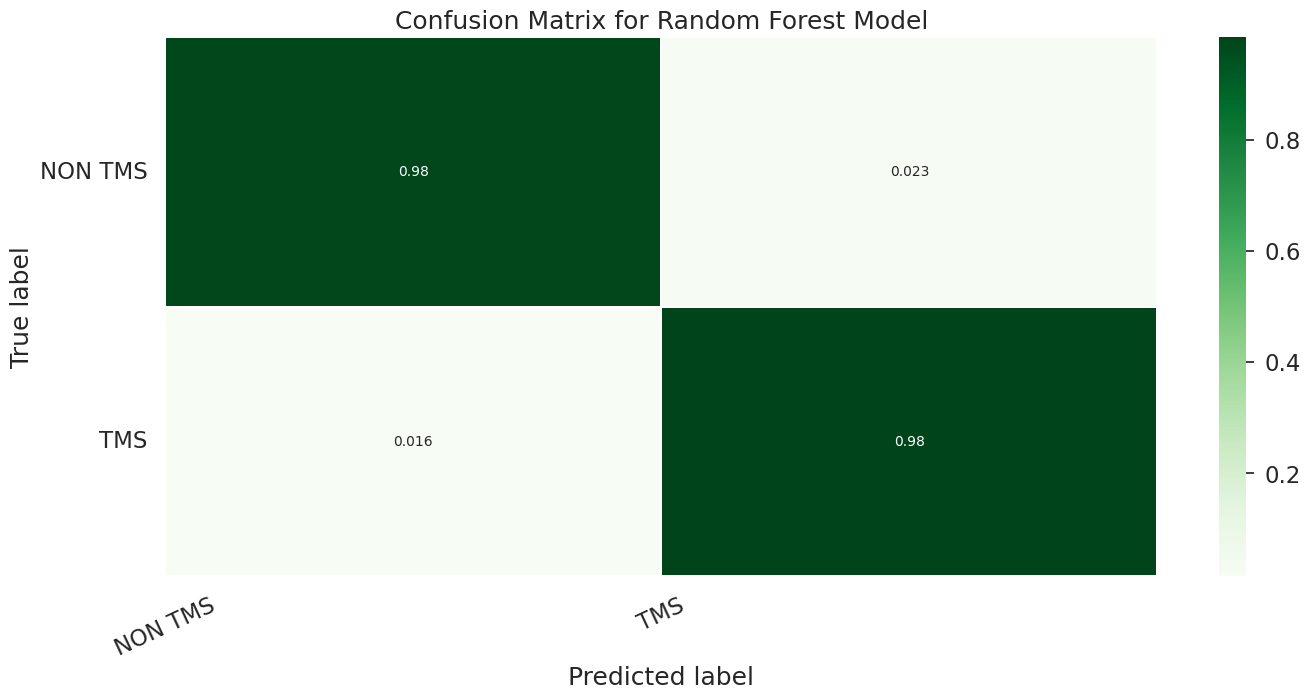

In [ ]:
matrix = confusion_matrix(y_testNEW2, RFpredictions2)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.5)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['NON TMS', 'TMS']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

In [ ]:
# Assuming you have trained a Random Forest model named 'RFmodelNEW' on data 'X' and target 'y'

# Get the feature importances from the trained model
importances = RFmodelNEW2.feature_importances_

# Get the corresponding feature names
feature_names = X_NEW2.columns

# Create a dictionary mapping feature names to importances
feature_importances = dict(zip(feature_names, importances))

# Sort the feature importances dictionary by importance scores
sorted_importances = sorted(feature_importances.items(), key=lambda x: x[1], reverse=True)

# Get the top 25 features and their importances
top_features = sorted_importances[:25]

# Print the top 25 features and their importances
for feature, importance in top_features:
    print(f"{feature}: {importance}")

OCH_TOTAL_QTY: 0.13730523545232368
SHIP_LOS_UPS Ground: 0.11222999109767492
PH_SCHED_DLVRY_DATE_YES: 0.061140167718297576
ORIGIN_Louisville_KY: 0.04988401045247626
PH_SCHED_DLVRY_DATE_NO: 0.04948945317570664
SHIP_CARRIER_Federal Express: 0.048903618600407546
SHIP_LOS_UPS Next Day Air Saver: 0.042103510091996636
SHIP_CARRIER_United Parcel Service: 0.03845528437572734
SHIP_MONTH_11: 0.034036641622795634
ORIGIN_Harrisburg_PA: 0.031401221861750206
SHIP_WT_ACCURACY_VERY HIGH: 0.031007575731863926
SHIP_WT_ACCURACY_OK: 0.027293559174353582
ORIGIN_FortWorth_TX: 0.025338694077288223
ORIGIN_Freedom_PA: 0.021479828151119054
SHIP_WT_ACCURACY_LOW: 0.01751301590825903
SHIP_LOS_FedEx Custom Critical: 0.017257786832391306
ORIGIN_Buford_GA: 0.017039373981082472
OPH_TOTAL_NBR_OF_CARTON: 0.016919856863469848
ORIGIN_Reno_NV: 0.016803672268635928
ORIGIN_Duluth_GA: 0.014229697086244277
SHIP_WT_ACCURACY_HIGH: 0.012557594644981341
SHIP_WT_ACCURACY_VERY LOW: 0.011368620748383483
SHIP_LOS_UPS 2nd Day Air: 0.009

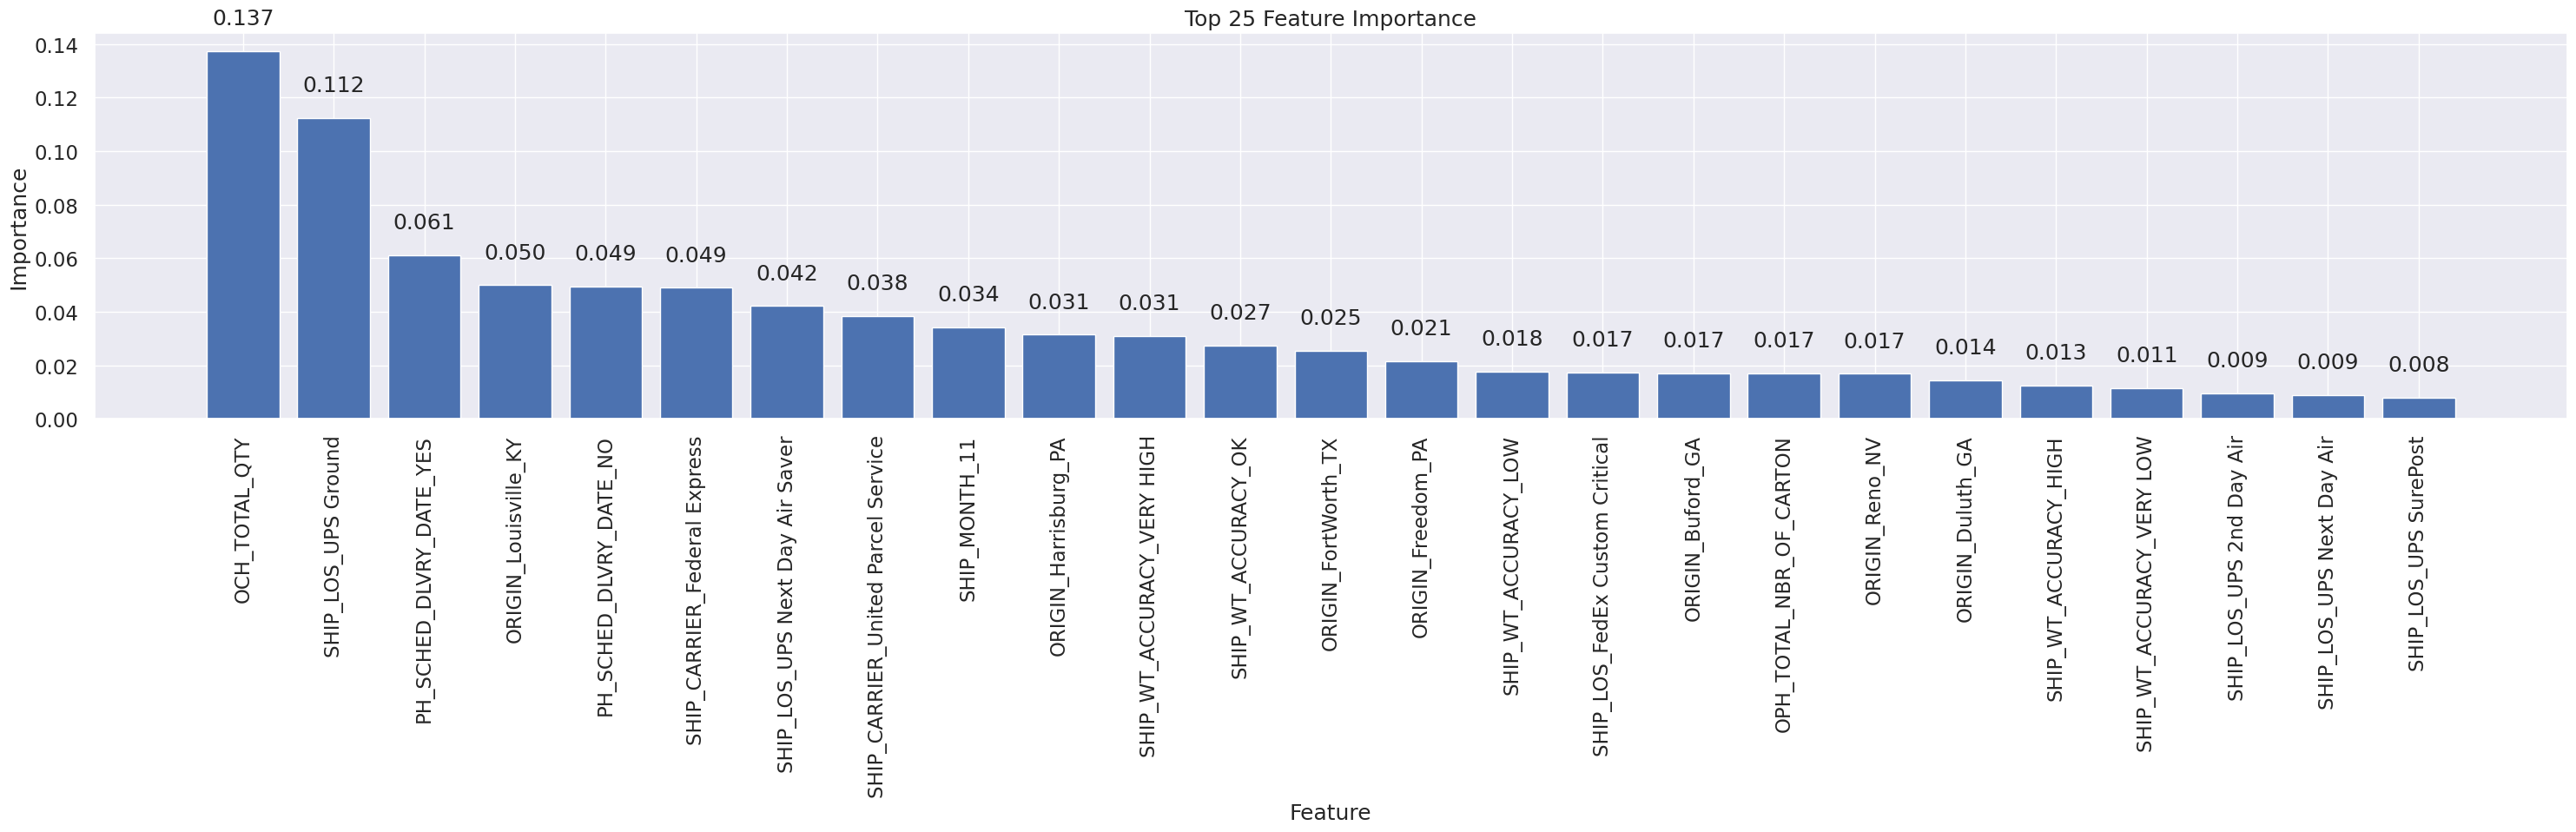

In [ ]:
# Get feature importances from the trained model
importances = RFmodelNEW2.feature_importances_

# Create a DataFrame with feature names and their importance scores
feature_importances = pd.DataFrame({'Feature': X_NEW2.columns, 'Importance': importances})

# Sort the features by their importance scores
feature_importances = feature_importances.sort_values('Importance', ascending=False)

# Select the top 25 features
top_25_features = feature_importances.head(25)

# Plot the top 25 feature importance with values
plt.figure(figsize=(30, 10))
plt.bar(top_25_features['Feature'], top_25_features['Importance'])
plt.xticks(rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Top 25 Feature Importance')

# Add values to the bars
for i, importance in enumerate(top_25_features['Importance']):
    plt.text(i, importance + 0.01, f'{importance:.3f}', ha='center')

plt.tight_layout()
plt.show()

In [ ]:
# training the classifier on training data
svcNEW2 = SGDClassifier(loss = "log", n_jobs = -1, max_iter=2, random_state = 42)
svcNEW2.fit(X_trainNEW2, y_trainNEW2)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


SGDClassifier(loss='log', max_iter=2, n_jobs=-1, random_state=42)

In [ ]:
y_train_probsNEW2 = svcNEW2.predict_proba(X_trainNEW2)
y_test_probsNEW2 = svcNEW2.predict_proba(X_testNEW2)

In [ ]:
train_loss_svcNEW2 = log_loss(y_trainNEW2, y_train_probsNEW2)
test_loss_svcNEW2 = log_loss(y_testNEW2, y_test_probsNEW2)

print(f"Log loss on Train Data using Support Vectors Model: {train_loss_svcNEW2}")
print(f"Log loss on Test Data using Support Vectors Model: {test_loss_svcNEW2}")

Log loss on Train Data using Support Vectors Model: 5.031967092239393
Log loss on Test Data using Support Vectors Model: 5.058188161992899


In [ ]:
def plot_confusion_matrix(truths, predictions, labels = df_NEW2['TMS'].unique()):
    print("\n")
    matrix = confusion_matrix(truths, predictions)
    # matrix = (4,4) matrix where each cell (i,j) represents number of points of class i which are predicted as of class j
    precision = matrix/np.sum(matrix, axis = 0)
    # precision = (4,4) matrix where each cell (i,j) represents it's precision i.e. TP/(TP+FP) which is value/column_sum in confusion matrix
    recall = (matrix.T/np.sum(matrix, axis = 1)).T
    # recall = (4,4) matrix where each cell (i,j) represents it's recall i.e. TP/(TP+FN) which is value/row_sum in confusion matrix

    # creating axes to draw plots
    fig, ax = plt.subplots(1, 3)
    cmap = sns.light_palette("purple")

    # plotting the matrices using heatmaps from seaborn library
    titles = [("Confusion matrix", matrix), ("Precision matrix", precision), ("Recall matrix", recall)]
    for i, j in enumerate(titles):
        if j[0] == "Confusion matrix":
            sns.heatmap(j[1], annot = True, cmap = cmap, fmt = "", xticklabels = labels, yticklabels = labels, ax = ax[i])
        else:
            sns.heatmap(j[1], annot = True, cmap = cmap, vmin = 0, vmax = 1, fmt = ".2f", xticklabels = labels, yticklabels = labels, ax = ax[i])
        ax[i].set_xticklabels(ax[i].get_xmajorticklabels())
        ax[i].set_yticklabels(ax[i].get_ymajorticklabels(), rotation = 0)
        ax[i].set_title(j[0], fontdict = title_font)
        ax[i].set_xlabel("Predicted labels", fontdict = label_font)
        ax[i].set_ylabel("Original labels", fontdict = label_font)

    # rescaling the figure
    fig.set_figheight(5)
    fig.set_figwidth(15)
    fig.tight_layout()

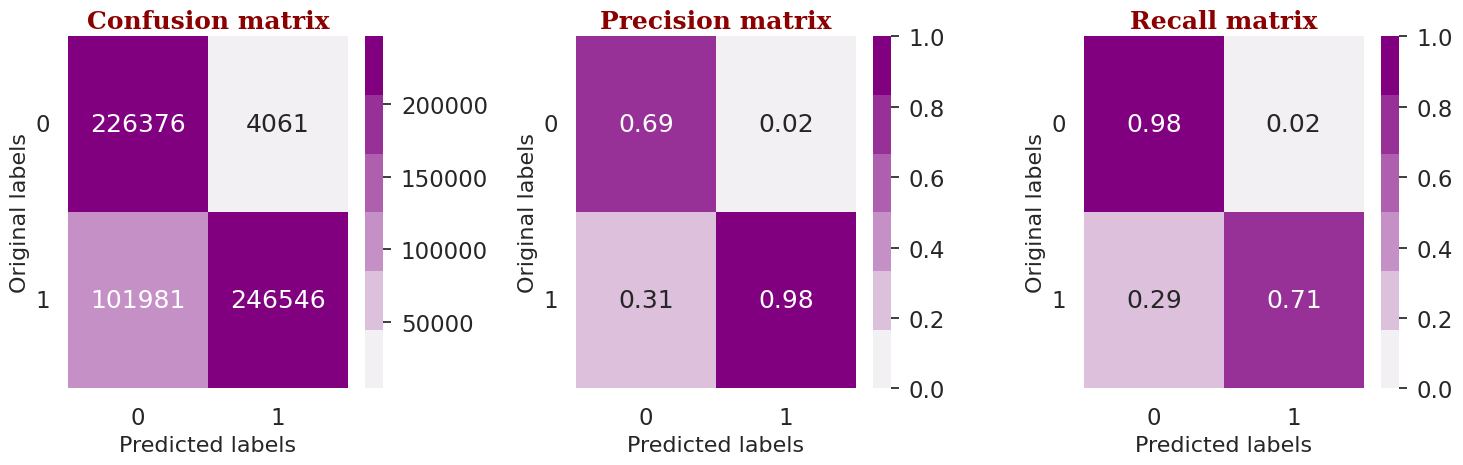

In [ ]:
title_font = {'family': 'serif', 'color': 'darkred', 'weight': 'bold', 'size': 18}
label_font = {'weight': 'normal', 'size': 16}
y_test_predsNEW2 = svcNEW2.predict(X_testNEW2)
plot_confusion_matrix(y_testNEW2, y_test_predsNEW2)

In [ ]:
accuracyNEW2 = accuracy_score(y_testNEW2, y_test_predsNEW2)
print('SGD Classifier Accuracy of the model: {:.2f}%'.format(accuracyNEW2*100))

SGD Classifier Accuracy of the model: 81.68%


In [ ]:
svc_featuresNEW2 = svcNEW2.coef_[0]

FEATURES2 = pd.DataFrame(svc_featuresNEW2,
             X_trainNEW2.columns,
             columns=['coef'])\
            .sort_values(by='coef', ascending=False)

print("The top 25 important variables in the SGD Model are \n", FEATURES2[:25])

The top 25 important variables in the SGD Model are 
                                           coef
SHIP_CARRIER_United Parcel Service  138.829293
ORIGIN_Louisville_KY                130.247597
SHIP_LOS_UPS Ground                 127.938108
SHIP_WT_ACCURACY_OK                 105.251348
PH_SCHED_DLVRY_DATE_NO               90.577582
ORIGIN_Freedom_PA                    89.787838
EST_WEIGHT_CATEGORY_PARCEL           64.677521
SHIP_LOS_UPS Next Day Air            62.876928
SHIP_WT_ACCURACY_VERY HIGH           58.330060
DOM_INTL_DOM                         57.189406
PH_SHIPTO_CNTRY_OR_TERRITORY_US      57.189406
SHIP_LOS_UPS SurePost                55.949946
ACT_WEIGHT_CATEGORY_PARCEL           54.305059
SHIP_MONTH_1                         49.476696
SHIP_MONTH_12                        48.680690
SHIP_MONTH_2                         48.035372
ORIGIN_Fairdale_KY                   33.590780
SHIP_TIME_CATEGORY_Morning           27.845217
SHIP_TIME_CATEGORY_Overnight         27.484364
SHIP_L

In [ ]:
# Initialize the logistic regression model
LRmodelNEW2 = LogisticRegression()

# Train the model on the training data
LRmodelNEW2.fit(X_trainNEW2, y_trainNEW2)

# Make predictions on the test data
y_predNEW2 = LRmodelNEW2.predict(X_testNEW2)

# Calculate the accuracy of the model
accuracyNEW2 = accuracy_score(y_testNEW2, y_predNEW2)
print("Accuracy:", accuracyNEW2)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.9078181026799593


In [ ]:
# Get the feature importance (coefficients) from the model
feature_importance2 = np.abs(LRmodelNEW2.coef_[0])

# Create a dictionary mapping features to their importance
feature_importance_dict2 = dict(zip(X_NEW2.columns, feature_importance2))

# Sort the features based on importance (descending order)
sorted_features2 = sorted(feature_importance_dict2.items(), key=lambda x: x[1], reverse=True)

# Print the top N most significant features
top_n = 25  # Number of top features to display
for feature, importance in sorted_features2[:top_n]:
    print(f"Feature: {feature}, Importance: {importance}")

Feature: ORIGIN_Louisville_KY, Importance: 3.159447425128568
Feature: SHIP_LOS_UPS Next Day Air Saver, Importance: 2.8896818355361966
Feature: SHIP_LOS_UPS Ground, Importance: 2.44073100847661
Feature: ORIGIN_FortWorth_TX, Importance: 1.8974068324389666
Feature: SHIP_MONTH_11, Importance: 1.858978078947287
Feature: SHIP_WT_ACCURACY_OK, Importance: 1.625500605859524
Feature: ORIGIN_Freedom_PA, Importance: 1.3629186957969681
Feature: ORIGIN_Buford_GA, Importance: 1.2607766904232953
Feature: SHIP_CARRIER_Federal Express, Importance: 1.2414397109948943
Feature: SHIP_WT_ACCURACY_VERY LOW, Importance: 1.100433271324828
Feature: ORIGIN_Reno_NV, Importance: 1.0356786781756138
Feature: ORIGIN_Duluth_GA, Importance: 0.9395854334978777
Feature: SHIP_WT_ACCURACY_HIGH, Importance: 0.9130483411443856
Feature: SHIP_LOS_FedEx Custom Critical, Importance: 0.892906055101229
Feature: SHIP_WT_ACCURACY_LOW, Importance: 0.7871876109270765
Feature: ACT_WEIGHT_CATEGORY_PARCEL, Importance: 0.7710612254828986
F

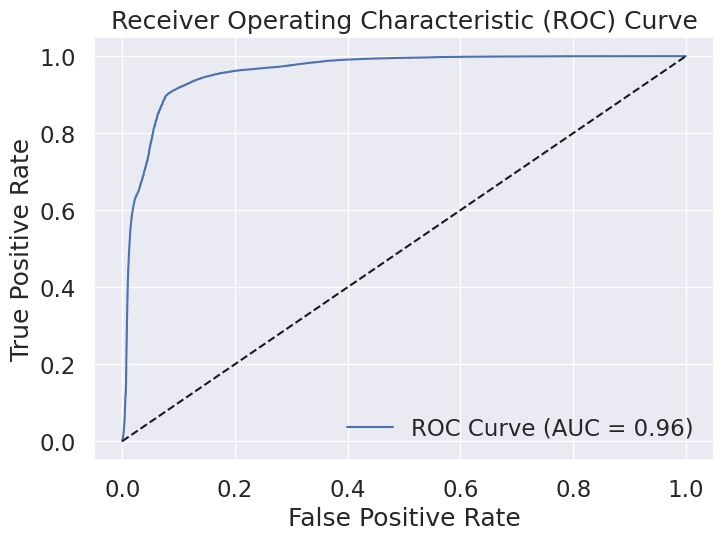

In [ ]:
# Make predictions on the test data
y_pred_prob2 = LRmodelNEW2.predict_proba(X_testNEW2)[:, 1]

# Calculate the fpr, tpr, and threshold values for the ROC curve
fpr, tpr, thresholds = roc_curve(y_testNEW2, y_pred_prob2)

# Calculate the AUC score
auc_score2 = roc_auc_score(y_testNEW2, y_pred_prob2)

# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC Curve (AUC = {:.2f})'.format(auc_score2))
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random guess
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

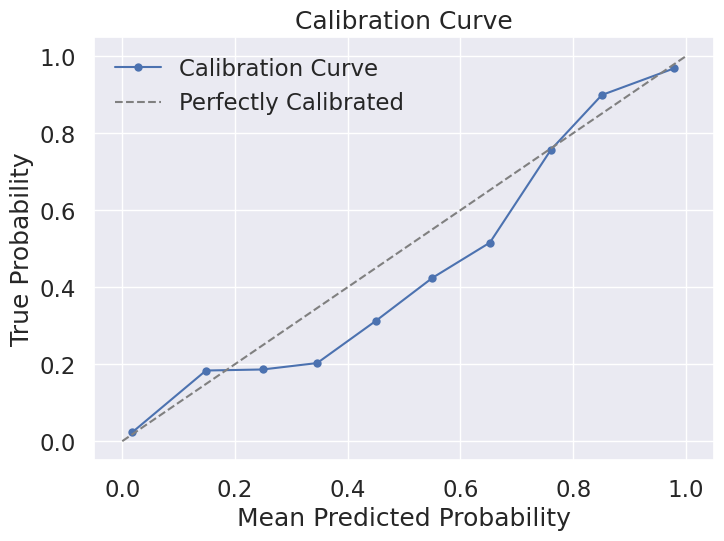

In [ ]:
# Calculate the predicted probabilities and true probabilities for the calibration curve
prob_true, prob_pred = calibration_curve(y_testNEW2, y_pred_prob2, n_bins=10)

# Plot the Calibration Curve
plt.plot(prob_pred, prob_true, marker='o', linestyle='-', label='Calibration Curve')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('True Probability')
plt.title('Calibration Curve')
plt.legend()
plt.show()

In [ ]:
pip install --upgrade pip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install 'neptune-contrib[monitoring]>=0.24.9'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.2/74.2 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 448.2/448.2 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.9/107.9 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.1/214.1 kB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 720.6/720.6 kB 35.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 925.8/925.8 kB 51.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/5

In [ ]:
import neptune
import pandas as pd
import xgboost as xgb
from neptunecontrib.monitoring.xgboost_monitor import neptune_callback

/usr/local/lib/python3.10/dist-packages/neptunecontrib/monitoring/xgboost_monitor.py:21: UserWarning: neptunecontrib.monitoring.xgboost_monitor was moved to neptunecontrib.monitoring.xgboost
neptunecontrib.monitoring.xgboost_monitor will be removed in future releases.

  warnings.warn(message)


In [ ]:
dtrain = xgb.DMatrix(X_trainNEW2, label=y_trainNEW2)
dtest = xgb.DMatrix(X_testNEW2, label=y_testNEW2)

In [ ]:
params = {'max_depth': 5,
          'eta': 0.5,
          'gamma': 0.1,
          'silent': 1,
          'subsample': 1,
          'lambda': 1,
          'alpha': 0.35,
          'objective': 'reg:linear',
          'eval_metric': ['mae', 'rmse']}
watchlist = [(dtest, 'eval'), (dtrain, 'train')]
num_round = 20

In [ ]:
params = {'max_depth': 5,
          'eta': 0.5,
          'gamma': 0.1,
          'silent': 1,
          'subsample': 1,
          'lambda': 1,
          'alpha': 0.35,
          'objective': 'binary:logistic',
          'eval_metric': ['mae', 'rmse', 'logloss']}

num_rounds = 100

XGBmodelNEW2 = xgb.train(params, dtrain, num_rounds)

[00:25:45] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



In [ ]:
y_predXGBNEW2 = XGBmodelNEW2.predict(dtest)

In [ ]:
feature_importance = XGBmodelNEW2.get_score(importance_type='gain')
sorted_importance = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)
top_25_features = sorted_importance[:25]
for feature, importance_score in top_25_features:
    print(f"{feature}: {importance_score}")

SHIP_LOS_UPS Ground: 19610.400390625
SHIP_LOS_UPS SurePost: 10872.53515625
ORIGIN_Buford_GA: 5945.1005859375
ORIGIN_FortWorth_TX: 5909.35546875
ORIGIN_Freedom_PA: 5151.82861328125
ACT_WEIGHT_CATEGORY_PARCEL: 4770.46044921875
SHIP_MONTH_11: 2924.1650390625
SHIP_CARRIER_Federal Express: 2814.660888671875
ORIGIN_Memphis_TN: 2600.88134765625
ORIGIN_Louisville_KY: 2543.197265625
ORIGIN_Fairdale_KY: 2216.17333984375
ORIGIN_Harrisburg_PA: 2161.154052734375
ORIGIN_Duluth_GA: 2142.701171875
SHIP_LOS_UPS Next Day Air Saver: 2106.0439453125
SHIP_LOS_Standard: 1898.791015625
SHIP_LOS_UPS Next Day Air: 1877.83154296875
OCH_TOTAL_QTY: 1748.0877685546875
ORIGIN_CarolStream_IL: 1736.8572998046875
SHIP_LOS_FedEx Priority Overnight: 1557.564453125
SHIP_WT_ACCURACY_OK: 1461.9766845703125
SHIP_WT_ACCURACY_HIGH: 1290.5406494140625
PH_SCHED_DLVRY_DATE_NO: 1284.0728759765625
ORIGIN_Durham_NC: 1084.858642578125
OPH_TOTAL_NBR_OF_CARTON: 1083.861083984375
ORIGIN_MiraLoma_CA: 981.9979858398438


In [ ]:
y_pred_labels = (y_predXGBNEW2 > 0.5).astype(int)  # Convert probabilities to binary labels
accuracy = accuracy_score(y_testNEW2, y_pred_labels)
print("Accuracy:", accuracy)

Accuracy: 0.9786238868047064


In [ ]:
fpr, tpr, thresholds = roc_curve(y_testNEW2, y_predXGBNEW2)

In [ ]:
auc_score = roc_auc_score(y_testNEW2, y_predXGBNEW2)
print("AUC-ROC Score:", auc_score)

AUC-ROC Score: 0.9975684064297369


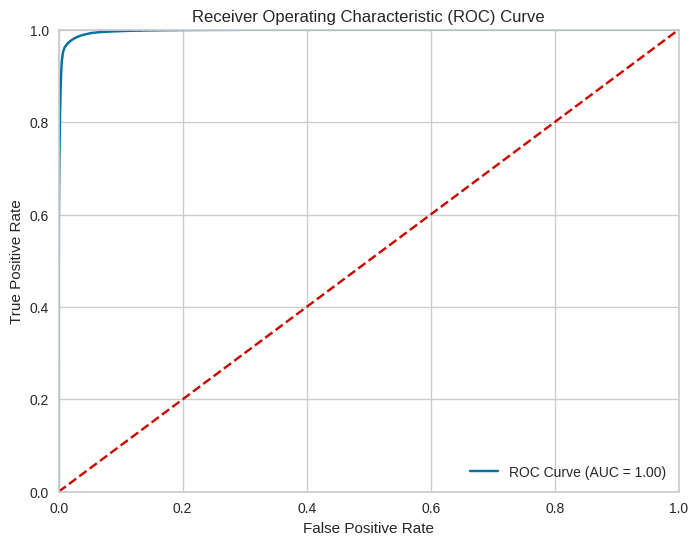

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label="ROC Curve (AUC = %0.2f)" % auc_score)
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)  # Create KNN model with 5 neighbors
knn.fit(X_trainNEW2, y_trainNEW2)  # Train the model

KNeighborsClassifier()

In [ ]:
y_predKNN = knn.predict(X_testNEW2)

KeyboardInterrupt: ignored

In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers

In [ ]:
nnmodel = models.Sequential()
nnmodel.add(layers.Dense(64, activation='relu', input_shape=(X_trainNEW2.shape[1],)))
nnmodel.add(layers.Dense(64, activation='relu'))
nnmodel.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
nnmodel.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
nnmodel.fit(X_trainNEW2, y_trainNEW2, epochs=100, batch_size=50000)


Epoch 1/100
47/47 [==============================] - 2s 47ms/step - loss: 0.0465 - accuracy: 0.9825
Epoch 2/100
47/47 [==============================] - 2s 46ms/step - loss: 0.0464 - accuracy: 0.9826
Epoch 3/100
47/47 [==============================] - 2s 47ms/step - loss: 0.0474 - accuracy: 0.9824
Epoch 4/100
47/47 [==============================] - 2s 48ms/step - loss: 0.0462 - accuracy: 0.9826
Epoch 5/100
47/47 [==============================] - 2s 47ms/step - loss: 0.0466 - accuracy: 0.9826
Epoch 6/100
47/47 [==============================] - 2s 47ms/step - loss: 0.0471 - accuracy: 0.9824
Epoch 7/100
47/47 [==============================] - 2s 48ms/step - loss: 0.0479 - accuracy: 0.9823
Epoch 8/100
47/47 [==============================] - 2s 48ms/step - loss: 0.0470 - accuracy: 0.9826
Epoch 9/100
47/47 [==============================] - 2s 47ms/step - loss: 0.0491 - accuracy: 0.9821
Epoch 10/100
47/47 [==============================] - 2s 49ms/step - loss: 0.0473 - accuracy: 0.9824

In [ ]:
y_pred_probnn = nnmodel.predict(X_testNEW2)
y_prednn = np.argmax(y_pred_probnn, axis=1)

18093/18093 [==============================] - 19s 1ms/step


In [ ]:
cm = confusion_matrix(y_testNEW2, y_prednn)

print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[230153      0]
 [348811      0]]


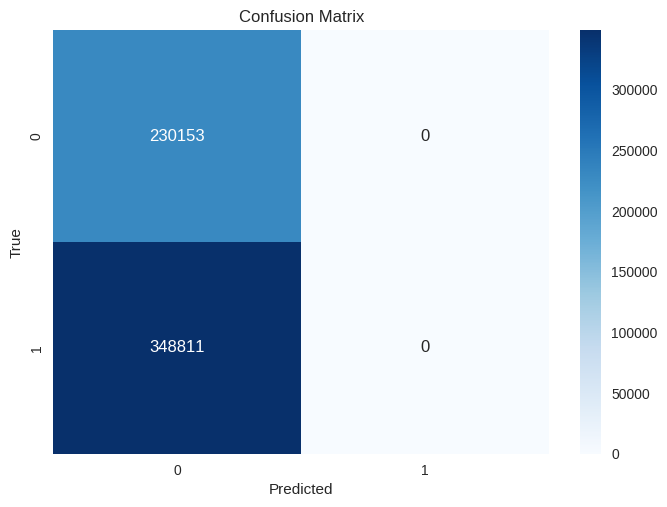

In [ ]:
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
weights = nnmodel.get_weights()

In [ ]:
feature_importancenn = np.abs(weights[0]).sum(axis=0)

In [ ]:
top_indices = np.argsort(feature_importancenn)[::-1][:25]
top_features = X_trainNEW2.columns[top_indices].tolist()
top_scores = feature_importancenn[top_indices]

In [ ]:
for feature, score in zip(top_features, top_scores):
    print(f"{feature}: {score}")

ORIGIN_Harrisburg_PA: 426.1329650878906
PH_SHIPTO_STATE_8: 406.65911865234375
PH_SHIPTO_STATE_IN: 346.554443359375
PH_SHIPTO_STATE_BC: 322.3367614746094
PH_SHIPTO_STATE_14: 321.7686767578125
OCH_TOTAL_QTY: 315.3976745605469
PH_SHIPTO_STATE_IL: 285.78204345703125
ORIGIN_Reno_NV: 272.7580871582031
PH_SHIPTO_STATE_CT: 267.7609558105469
PH_SHIPTO_STATE_11: 250.7132568359375
ORIGIN_FortWorth_TX: 239.81944274902344
PH_SHIPTO_STATE_4: 237.82859802246094
PH_SHIPTO_STATE_AZ: 236.310791015625
PH_SHIPTO_STATE_FL: 234.348388671875
PH_SHIPTO_STATE_AE: 232.69766235351562
ORIGIN_Fairdale_KY: 226.13397216796875
ORIGIN_Columbus_OH: 222.43748474121094
PH_SHIPTO_STATE_35: 220.29037475585938
PH_SHIPTO_STATE_HI: 215.46913146972656
PH_SHIPTO_STATE_28: 203.3338623046875
PH_SHIPTO_STATE_DE: 202.21701049804688
PH_SHIPTO_STATE_GU: 192.0589141845703
PH_SHIPTO_STATE_42: 189.57992553710938
PH_SHIPTO_STATE_Fl: 182.67474365234375
ORIGIN_Durham_NC: 182.66845703125


In [ ]:
df_NEW3 = df_NEW2

In [ ]:
import re
df_NEW3 = df_NEW3.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [ ]:
import lightgbm as lgb

In [ ]:
  model=cconstruct_model(0.001)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      320       
                                                                 
 conv2d_1 (Conv2D)           (None, 124, 124, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 62, 62, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 58, 58, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 29, 29, 64)       0         
 2D)                                                  

In [ ]:
from ann_visualizer.visualize import ann_viz
ann_viz(nnmodel, view=True, filename="cconstruct_model", title="CNN — Model 1 — Simple Architecture")

In [ ]:
ann_viz

<function ann_visualizer.visualize.ann_viz(model, view=True, filename='network.gv', title='My Neural Network')>

In [ ]:
pip install lightgbm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import lightgbm as lgb
from lightgbm import LGBMRegressor

In [ ]:
lgb_train = lgb.Dataset(X_trainNEW2, y_trainNEW2)
lgb_eval = lgb.Dataset(X_testNEW2, y_testNEW2, reference=lgb_train)

In [ ]:
y_NEW3 = df_NEW3['TMS']
X_NEW3 = df_NEW3.drop('TMS',axis=1)

In [ ]:
from sklearn.model_selection import train_test_split
X_trainNEW3, X_testNEW3, y_trainNEW3, y_testNEW3 = train_test_split(X_NEW3, y_NEW3, test_size = 0.20, random_state = 42)

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, SelectPercentile

In [ ]:
X_NEW3_new = SelectKBest(chi2, k=25).fit(X_NEW3, y_NEW3)
feature_ids2 = X_NEW3_new.get_support(indices=True)
feature_names2 = X_NEW3.columns[feature_ids2]
feature_names2

Index(['OCH_TOTAL_QTY', 'ORIGIN_Buford_GA', 'ORIGIN_CarolStream_IL',
       'ORIGIN_Duluth_GA', 'ORIGIN_FortWorth_TX', 'ORIGIN_Freedom_PA',
       'ORIGIN_Louisville_KY', 'ORIGIN_Reno_NV', 'SHIP_CARRIER_FederalExpress',
       'SHIP_CARRIER_UnitedParcelService', 'SHIP_LOS_FedEx2Day',
       'SHIP_LOS_FedExCustomCritical', 'SHIP_LOS_FedExGround',
       'SHIP_LOS_FedExPriorityOvernight', 'SHIP_LOS_FedExStandardOvernight',
       'SHIP_LOS_UPS2ndDayAir', 'SHIP_LOS_UPSGround',
       'SHIP_LOS_UPSNextDayAirSaver', 'PH_SCHED_DLVRY_DATE_NO',
       'PH_SCHED_DLVRY_DATE_YES', 'SHIP_WT_ACCURACY_HIGH',
       'SHIP_WT_ACCURACY_LOW', 'SHIP_WT_ACCURACY_VERYHIGH',
       'SHIP_WT_ACCURACY_VERYLOW', 'SHIP_MONTH_11'],
      dtype='object')

In [ ]:
pip install shapash

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 652.7/652.7 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 65.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 39.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 88.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.6/220.6 kB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 642.7/642.7 kB 43.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 55.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 21.1 MB/s eta 0:00:00
  Created wheel for dash-renderer: filename=dash_renderer-1.8.3-py3-none-any.whl size=1013920

In [ ]:
regressor = LGBMRegressor(n_estimators=200).fit(X_trainNEW3,y_trainNEW3)

In [ ]:
!pip uninstall numba
!pip install -U numba

Found existing installation: numba 0.56.4
Uninstalling numba-0.56.4:
  Would remove:
    /usr/local/bin/numba
    /usr/local/bin/pycc
    /usr/local/lib/python3.10/dist-packages/numba-0.56.4.dist-info/*
    /usr/local/lib/python3.10/dist-packages/numba/*
Proceed (Y/n)? Y
  Successfully uninstalled numba-0.56.4
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 36.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 MB 39.4 MB/s eta 0:00:00
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.39.1
    Uninstalling llvmlite-0.39.1:
      Successfully uninstalled llvmlite-0.39.1


In [ ]:
from shapash.explainer.smart_explainer import SmartExplainer


ImportError: ignored

In [ ]:
from shapash.explainer import SmartExplainer
xpl = SmartExplainer()

xpl.compile(
    x=X_testNEW3,
    model=regressor
)
xpl.plot.features_importance()

ImportError: ignored

In [ ]:
lgb_train = lgb.Dataset(X_trainNEW3, y_trainNEW3)
lgb_eval = lgb.Dataset(X_testNEW3, y_testNEW3, reference=lgb_train)

In [ ]:
clf = lgb.LGBMClassifier()
clf.fit(X_trainNEW3, y_trainNEW3)

LGBMClassifier()

In [ ]:
y_predLGB=clf.predict(X_testNEW3)

In [ ]:
from sklearn.metrics import accuracy_score
accuracy=accuracy_score(y_predLGB, y_testNEW3)
print('LightGBM Model accuracy score: {0:0.4f}'.format(accuracy_score(y_testNEW3, y_predLGB)))

LightGBM Model accuracy score: 0.9762


In [ ]:
y_pred_trainLGB = clf.predict(X_trainNEW3)

In [ ]:
print('Training-set accuracy score: {0:0.4f}'. format(accuracy_score(y_trainNEW3, y_pred_trainLGB)))

Training-set accuracy score: 0.9764


In [ ]:
# print the scores on training and test set

print('Training set score: {:.4f}'.format(clf.score(X_trainNEW3, y_trainNEW3)))

print('Test set score: {:.4f}'.format(clf.score(X_testNEW3, y_testNEW3)))

Training set score: 0.9764
Test set score: 0.9762


In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_testNEW3, y_predLGB)
print('Confusion matrix\n\n', cm)
print('\nTrue Positives(TP) = ', cm[0,0])
print('\nTrue Negatives(TN) = ', cm[1,1])
print('\nFalse Positives(FP) = ', cm[0,1])
print('\nFalse Negatives(FN) = ', cm[1,0])

Confusion matrix

 [[223700   6453]
 [  7330 341481]]

True Positives(TP) =  223700

True Negatives(TN) =  341481

False Positives(FP) =  6453

False Negatives(FN) =  7330


<Axes: >

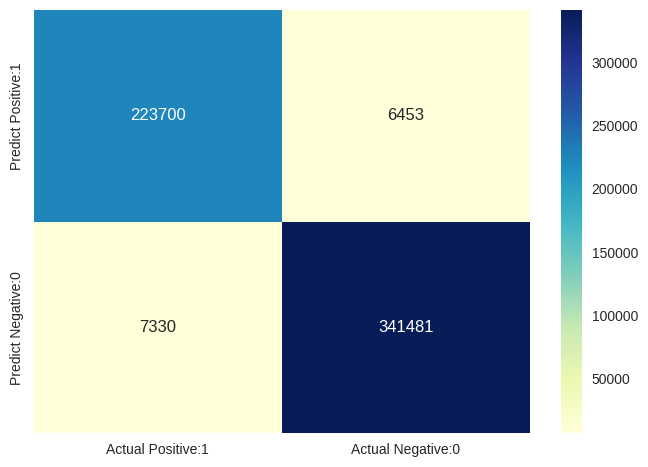

In [ ]:
# visualize confusion matrix with seaborn heatmap

cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'],
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_testNEW3, y_predLGB))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97    230153
           1       0.98      0.98      0.98    348811

    accuracy                           0.98    578964
   macro avg       0.97      0.98      0.98    578964
weighted avg       0.98      0.98      0.98    578964



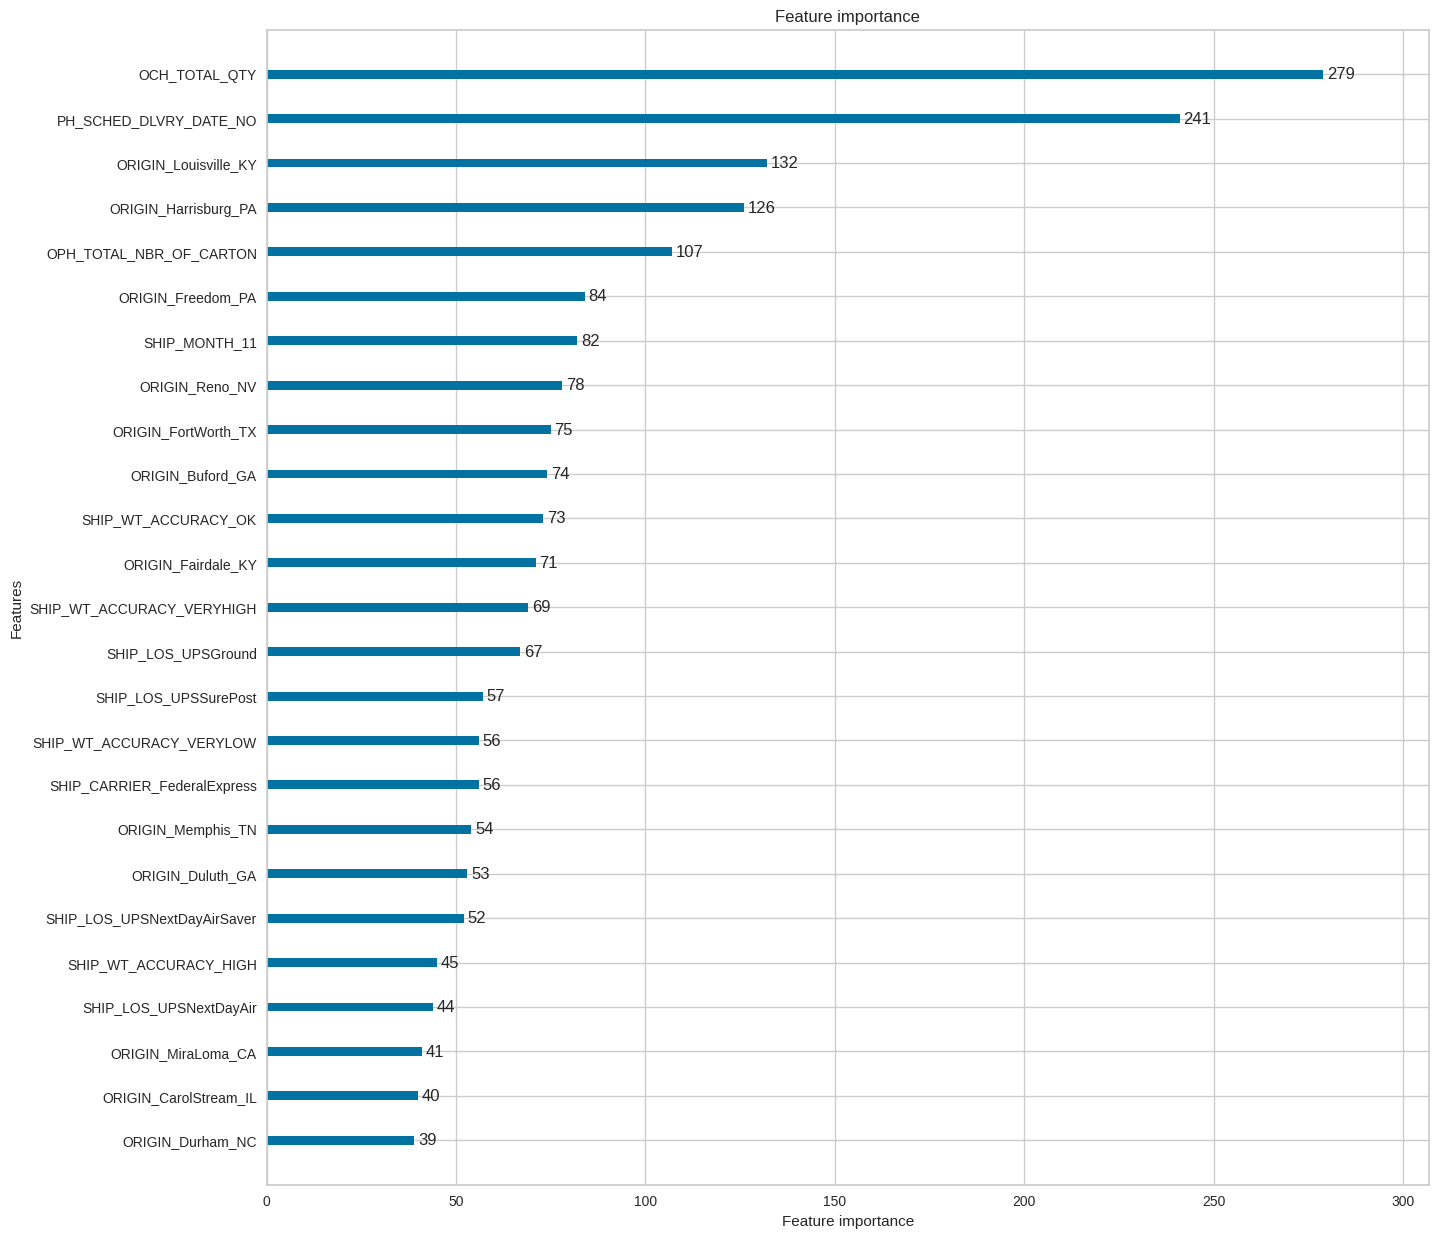

In [ ]:
ax = lgb.plot_importance(clf, max_num_features=25, figsize=(15,15))
plt.show()